In [1]:
import polars as pl
import openai
import unicodedata
import re
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
def normalize_text(s: str) -> str:
    # lowercasing, unicode normalization, removal of weird punctuation, extra whitespace
    if s is None:
        return ""
    # normalize unicode (e.g. cyrillic normalization)
    s = unicodedata.normalize("NFKC", s)
    s = s.lower()
    # remove extra spaces
    s = re.sub(r"\s+", " ", s).strip()
    # optional: remove non-cyrillic/latin punctuation or map them
    return s

def tokenize_simple(s: str) -> list[str]:
    # simple whitespace + punctuation split
    # you can expand with better tokenization (morphology, ru / by lexicons, etc.)
    s2 = re.sub(r"[^\wа-яёА-ЯЁ]+", " ", s)
    return s2.split()

In [3]:

client = openai.OpenAI(api_key=os.getenv("SCIBOX_API_KEY"), base_url="https://llm.t1v.scibox.tech/v1")


In [4]:
from sentence_transformers import SentenceTransformer
import torch

embedding_model = SentenceTransformer("BAAI/bge-m3")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
embedding_model = embedding_model.to(device)

# A batched version (for speed)
def get_embeddings_batch_local(texts: list[str]) -> list[list[float]]:
    return embedding_model.encode(texts)

/run/media/inejka/USB_SSD_DATA/Python/t1-smart-support/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/run/media/inejka/USB_SSD_DATA/Python/t1-smart-support/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [60]:
def get_original_data() -> tuple[list[str], list[list[float]], list[str], list[list[float]]]:
    data = pl.read_csv("./data.csv", separator=";")
    df = data.with_columns([
        pl.col("text").map_elements(normalize_text).alias("query_norm"),
        pl.col("answer_pattern").map_elements(normalize_text).alias("answer_norm"),
        pl.col("category").map_elements(normalize_text).alias("cat_coarse_norm"),
        pl.col("subcategory").map_elements(normalize_text).alias("cat_fine_norm"),
    ])
    queries = df.select("query_norm").unique().to_series().to_list()
    embs = get_embeddings_batch_local(queries)
    answer_embs = get_embeddings_batch_local(df["answer_norm"].to_list())
    query_to_emb = {q: e for q, e in zip(queries, embs)}
    
    def query_to_emb_as_list(q: str) -> list[float]:
        return query_to_emb.get(q, None)

    df = df.with_columns([
        pl.col("query_norm").map_elements(query_to_emb_as_list, return_dtype=list[float]).alias("query_emb")
    ])
    df = df.drop("priority").drop("tags")
    return df["cat_fine_norm"].to_list(), df["query_emb"].to_list(), df["answer_pattern"].to_list(), answer_embs

def get_augumented_data() -> tuple[list[str], list[list[float]], list[str], list[list[float]]]:
    data = pl.read_csv("./data_extended.csv", separator=";")[262:]
    df = data.with_columns([
        pl.col("text").map_elements(normalize_text).alias("query_norm"),
        pl.col("answer_pattern").map_elements(normalize_text).alias("answer_norm"),
        pl.col("category").map_elements(normalize_text).alias("cat_coarse_norm"),
        pl.col("subcategory").map_elements(normalize_text).alias("cat_fine_norm"),
    ])
    queries = df.select("query_norm").unique().to_series().to_list()
    embs = get_embeddings_batch_local(queries)
    answer_embs = get_embeddings_batch_local(df["answer_norm"].to_list())
    query_to_emb = {q: e for q, e in zip(queries, embs)}
    
    def query_to_emb_as_list(q: str) -> list[float]:
        return query_to_emb.get(q, None)

    df = df.with_columns([
        pl.col("query_norm").map_elements(query_to_emb_as_list, return_dtype=list[float]).alias("query_emb")
    ])
    df = df.drop("priority").drop("tags")
    print("Augmented data size:", df.height)
    return df["cat_fine_norm"].to_list(), df["query_emb"].to_list(), df["answer_pattern"].to_list(), answer_embs

In [6]:
def get_bitext_data() -> tuple[list[str], list[str]]:
    data = pl.read_csv("./bitext.csv", separator=",")
    df = data.with_columns([
        pl.col("instruction").map_elements(normalize_text).alias("query_norm"),
        pl.col("response").map_elements(normalize_text).alias("answer_norm"),
        pl.col("category").map_elements(normalize_text).alias("cat_coarse_norm"),
        pl.col("intent").map_elements(normalize_text).alias("cat_fine_norm"),

    ])
    df = df.drop("flags")
    
    queries = df.select("query_norm").unique().to_series().to_list()
    embs = get_embeddings_batch_local(queries)
    query_to_emb = {q: e for q, e in zip(queries, embs)}
    
    def query_to_emb_as_list(q: str) -> list[float]:
        return query_to_emb.get(q, None)

    df = df.with_columns([
        pl.col("query_norm").map_elements(query_to_emb_as_list, return_dtype=list[float]).alias("query_emb")
    ])
    return df["cat_fine_norm"].to_list(), df["query_emb"].to_list()
# get_bitext_data()

In [7]:
def get_tickets_it_sup() -> tuple[list[str], list[list[float]]]:
    data = pl.read_csv("./tickets.csv", separator=",")
    df = data.with_columns([
        pl.col("text").map_elements(normalize_text).alias("query_norm"),
        pl.col("answer").map_elements(normalize_text).alias("answer_norm"),
        pl.col("category").map_elements(normalize_text).alias("cat_coarse_norm"),
        pl.col("subcategory").map_elements(normalize_text).alias("cat_fine_norm"),
    ])

    queries = df.select("query_norm").unique().to_series().to_list()
    embs = get_embeddings_batch_local(queries)
    query_to_emb = {q: e for q, e in zip(queries, embs)}
    
    def query_to_emb_as_list(q: str) -> list[float]:
        return query_to_emb.get(q, None)

    df = df.with_columns([
        pl.col("query_norm").map_elements(query_to_emb_as_list, return_dtype=list[float]).alias("query_emb")
    ])
    return df["cat_fine_norm"].to_list(), df["query_emb"].to_list()

In [8]:
def get_russian_intent_dataset() -> tuple[list[str], list[list[float]]]:
    data = pl.read_csv("./russian_intent_dataset.tsv", separator="\t")
    df = data.with_columns([
    pl.col("мне нужна справка").map_elements(normalize_text).alias("query_norm"),
    pl.col("statement_general").map_elements(normalize_text).alias("cat_fine_norm"),
    ])
    print(df)

    queries = df.select("query_norm").unique().to_series().to_list()
    embs = get_embeddings_batch_local(queries)
    query_to_emb = {q: e for q, e in zip(queries, embs)}
    
    def query_to_emb_as_list(q: str) -> list[float]:
        return query_to_emb.get(q, None)

    df = df.with_columns([
        pl.col("query_norm").map_elements(query_to_emb_as_list, return_dtype=list[float]).alias("query_emb")
    ])
    

    return df["cat_fine_norm"].to_list(), df["query_emb"].to_list()

In [100]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_recall_fscore_support, top_k_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import numpy as np

y, X, answers, answer_embs = get_original_data()
y_aug, X_aug, answers_aug, answer_embs_aug = get_augumented_data()

# Split augmented data (70/30 split)
X_aug_train, X_aug_test, y_aug_train, y_aug_test, answers_aug_train, answers_aug_test, ae_aug_train, ae_aug_test = train_test_split(
    X_aug, y_aug, answers_aug, answer_embs_aug, 
    test_size=0.35, random_state=42, stratify=y_aug
)

# Split original data (80/20 split - keep more for training since it's real)
X_real_train, X_real_test, y_real_train, y_real_test, answers_real_train, answers_real_test, ae_real_train, ae_real_test = train_test_split(
    X, y, answers, answer_embs,
    test_size=0.25, random_state=42, stratify=y
)

# Combine training data
X_train = X_real_train + X_aug_train           # Query embeddings
y_train = y_real_train + y_aug_train           # Category labels
answers_train = np.concatenate([answers_real_train,answers_aug_train], axis=0 ) # Answer texts
answer_embs_train = np.concatenate([ae_real_train, ae_aug_train], axis=0)        # Answer embeddings

# Test data (pure real for honest evaluation)
X_test = X_real_test + X_aug_test
y_test = y_real_test + y_aug_test
answers_test = np.concatenate([answers_real_test, answers_aug_test], axis=0)
answer_embs_test = np.concatenate([ae_real_test, ae_aug_test], axis=0)

print(f"Train: {len(X_train)} (query_emb, label, answer_text, answer_emb)")
print(f"Test:  {len(X_test)} (query_emb, label, answer_text, answer_emb)")

# L2 normalize ALL embeddings
def l2norm(a):
    a = np.array(a)
    n = np.linalg.norm(a, axis=1, keepdims=True) + 1e-9
    return a / n

E_train = l2norm(X_train)                    # Query embeddings
E_test = l2norm(X_test)                      # Query embeddings
E_answers_train = l2norm(answer_embs_train)  # Answer embeddings (for retrieval)
E_answers_test = l2norm(answer_embs_test)    # Answer embeddings (for evaluation)

print(f"\nEmbedding shapes:")
print(f"  E_train (queries): {E_train.shape}")
print(f"  E_test (queries):  {E_test.shape}")
print(f"  E_answers_train:   {E_answers_train.shape}")


Augmented data size: 1054
Train: 835 (query_emb, label, answer_text, answer_emb)
Test:  420 (query_emb, label, answer_text, answer_emb)

Embedding shapes:
  E_train (queries): (835, 1024)
  E_test (queries):  (420, 1024)
  E_answers_train:   (835, 1024)


In [10]:
print(y_train)

['банковские карточки', 'кредитные карты - plat/on', 'банковские карточки', 'дебетовые карты - signature', 'дебетовые карты - more', 'кредиты', 'дебетовые карты - signature', 'банковские карточки', 'рублевые - суперсемь', 'потребительские - старт', 'вклады и депозиты', 'карты рассрочки - кстати', 'карты рассрочки - кстати', 'кредиты', 'карты рассрочки - кстати', 'экспресс-кредиты - в магазинах-партнерах', 'банковские карточки', 'валютные - eur', 'кредитные карты - plat/on', 'кредитные карты - портмоне 2.0', 'рублевые - мои условия онлайн', 'кредиты', 'банковские карточки', 'банковские карточки', 'банковские карточки', 'кредитные карты - портмоне 2.0', 'дебетовые карты - форсаж', 'вклады и депозиты', 'карты рассрочки - черепаха', 'кредиты', 'карты рассрочки - кстати', 'валютные - rub', 'онлайн-сервисы', 'экспресс-кредиты - на роднае', 'кредитные карты - отличник', 'дебетовые карты - signature', 'кредиты', 'дебетовые карты - signature', 'банковские карточки', 'потребительские - легко пла

In [67]:

# --- 4) Simple kNN (cosine) to get y_pred (top-1) ---------------------------
# For cosine with NearestNeighbors, use metric="cosine" (it returns distances = 1 - cosine_sim)
knn = NearestNeighbors(n_neighbors=1, metric="cosine")
knn.fit(E_train)

dist, idx = knn.kneighbors(E_test, return_distance=True)   # idx: (n_test, 1)
# Map neighbor index to label
y_train_arr = np.array(y_train)
y_pred = y_train_arr[idx[:,0]].tolist()

# --- 5) Metrics: y_true / y_pred -------------------------------------------
y_true = y_test  # for clarity

acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Accuracy:  {acc:.4f}")
print(f"Macro F1:  {macro_f1:.4f}")
print("\nPer-class report:\n", classification_report(y_true, y_pred, digits=4))

Accuracy:  0.7069
Macro F1:  0.7113

Per-class report:
                                           precision    recall  f1-score   support

     автокредиты - автокредит без залога     0.9375    1.0000    0.9677        15
                     банковские карточки     0.7532    0.7250    0.7389        80
                          валютные - cny     0.9000    0.6923    0.7826        13
                          валютные - eur     0.8750    0.6364    0.7368        11
                          валютные - rub     0.5500    0.8462    0.6667        13
                          валютные - usd     0.4000    0.5455    0.4615        11
                       вклады и депозиты     0.7255    0.6491    0.6852        57
              дебетовые карты - infinite     1.0000    0.8000    0.8889        15
                  дебетовые карты - more     0.8125    0.7879    0.8000        33
             дебетовые карты - signature     0.7000    0.7368    0.7179        19
            дебетовые карты - комплимент 

Top 15 Most Common Misclassifications:
True: кредиты → Predicted: потребительские - на всё про всё | Count: 8
True: рублевые - мои условия → Predicted: валютные - usd | Count: 6
True: банковские карточки → Predicted: кредиты | Count: 6
True: рублевые - мои условия онлайн → Predicted: вклады и депозиты | Count: 6
True: вклады и депозиты → Predicted: рублевые - мои условия | Count: 5
True: рублевые - великий путь → Predicted: рублевые - подушка безопасности | Count: 5
True: рублевые - подушка безопасности → Predicted: рублевые - великий путь | Count: 5
True: карты рассрочки - черепаха → Predicted: карты рассрочки - кстати | Count: 5
True: карты рассрочки - кстати → Predicted: банковские карточки | Count: 5
True: банковские карточки → Predicted: дебетовые карты - форсаж | Count: 5
True: банковские карточки → Predicted: дебетовые карты - more | Count: 4
True: валютные - usd → Predicted: рублевые - мои условия | Count: 4
True: вклады и депозиты → Predicted: рублевые - мои условия онлайн | C

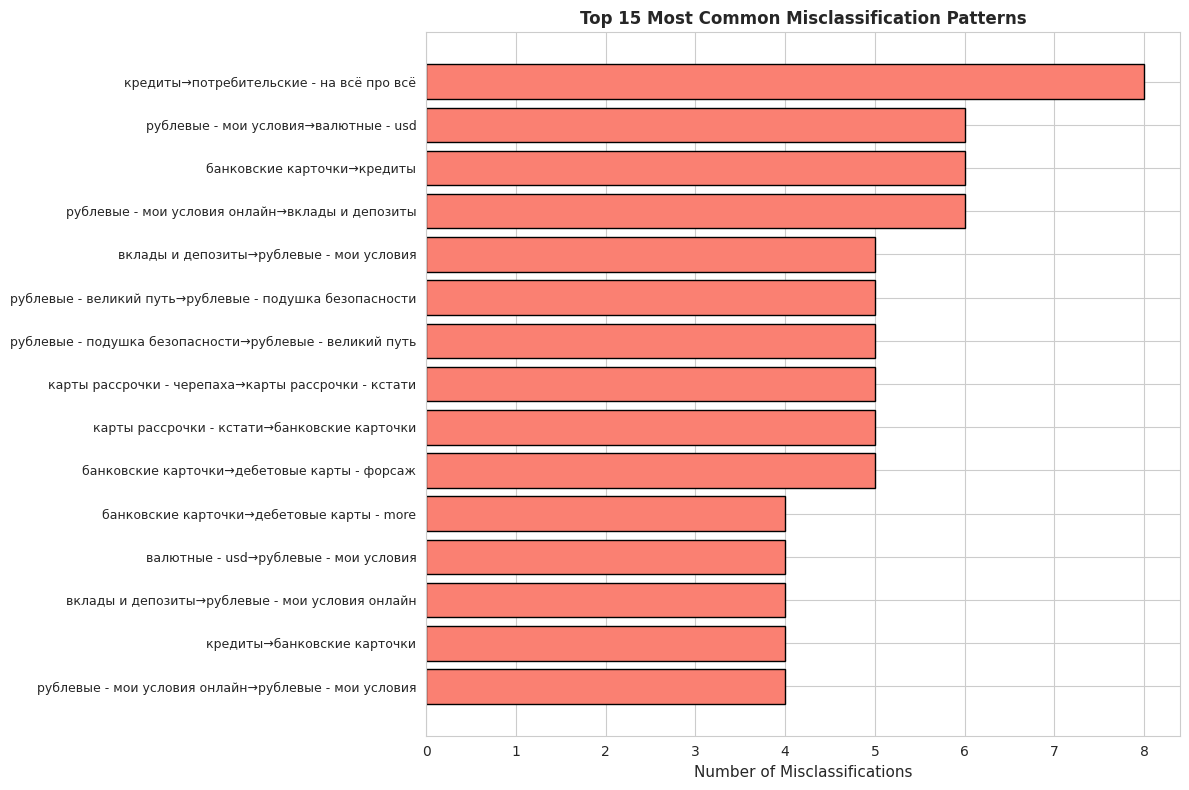

In [68]:
import matplotlib.pyplot as plt
# Most Common Misclassifications
misclassifications = []
for true_label, pred_label in zip(y_true, y_pred):
    if true_label != pred_label:
        misclassifications.append((true_label, pred_label))

if misclassifications:
    from collections import Counter
    most_common_errors = Counter(misclassifications).most_common(15)
    
    print("Top 15 Most Common Misclassifications:")
    print("="*80)
    for (true_label, pred_label), count in most_common_errors:
        print(f"True: {true_label} → Predicted: {pred_label} | Count: {count}")
    
    # Visualize
    error_labels = [f"{t}→{p}" for (t, p), _ in most_common_errors]
    error_counts = [count for _, count in most_common_errors]
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(error_labels)), error_counts, color='salmon', edgecolor='black')
    plt.yticks(range(len(error_labels)), error_labels, fontsize=9)
    plt.xlabel('Number of Misclassifications', fontsize=11)
    plt.title('Top 15 Most Common Misclassification Patterns', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No misclassifications found!")

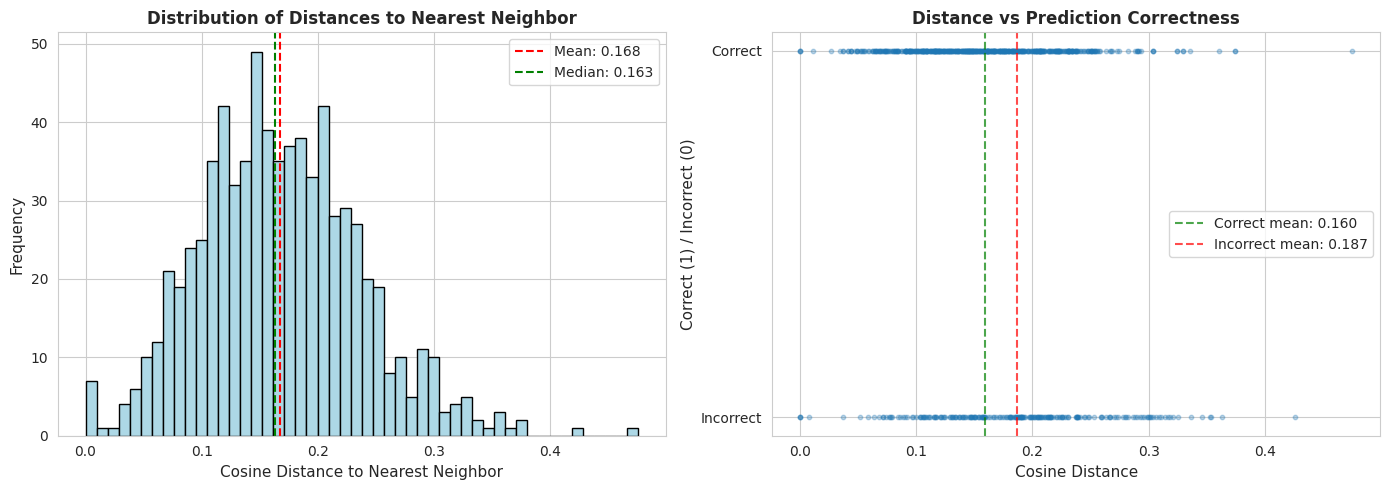

Mean distance for correct predictions: 0.1596
Mean distance for incorrect predictions: 0.1869
Accuracy: 0.7069 (521/737)


In [69]:
# Distance Analysis - How confident is the model?
plt.figure(figsize=(14, 5))

# Distance distribution
plt.subplot(1, 2, 1)
plt.hist(dist.flatten(), bins=50, edgecolor='black', color='lightblue')
plt.xlabel('Cosine Distance to Nearest Neighbor', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Distances to Nearest Neighbor', fontsize=12, fontweight='bold')
plt.axvline(dist.mean(), color='red', linestyle='--', label=f'Mean: {dist.mean():.3f}')
plt.axvline(np.median(dist), color='green', linestyle='--', label=f'Median: {np.median(dist):.3f}')
plt.legend()

# Distance vs Correctness
plt.subplot(1, 2, 2)
correct = np.array([1 if yt == yp else 0 for yt, yp in zip(y_true, y_pred)])
plt.scatter(dist.flatten(), correct, alpha=0.3, s=10)
plt.xlabel('Cosine Distance', fontsize=11)
plt.ylabel('Correct (1) / Incorrect (0)', fontsize=11)
plt.title('Distance vs Prediction Correctness', fontsize=12, fontweight='bold')
plt.yticks([0, 1], ['Incorrect', 'Correct'])

# Add mean distances for correct/incorrect
correct_dist_mean = dist[correct == 1].mean()
incorrect_dist_mean = dist[correct == 0].mean()
plt.axvline(correct_dist_mean, color='green', linestyle='--', alpha=0.7,
            label=f'Correct mean: {correct_dist_mean:.3f}')
plt.axvline(incorrect_dist_mean, color='red', linestyle='--', alpha=0.7,
            label=f'Incorrect mean: {incorrect_dist_mean:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Mean distance for correct predictions: {correct_dist_mean:.4f}")
print(f"Mean distance for incorrect predictions: {incorrect_dist_mean:.4f}")
print(f"Accuracy: {correct.mean():.4f} ({correct.sum()}/{len(correct)})")

In [70]:
# --- 6) Visualizations -------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)

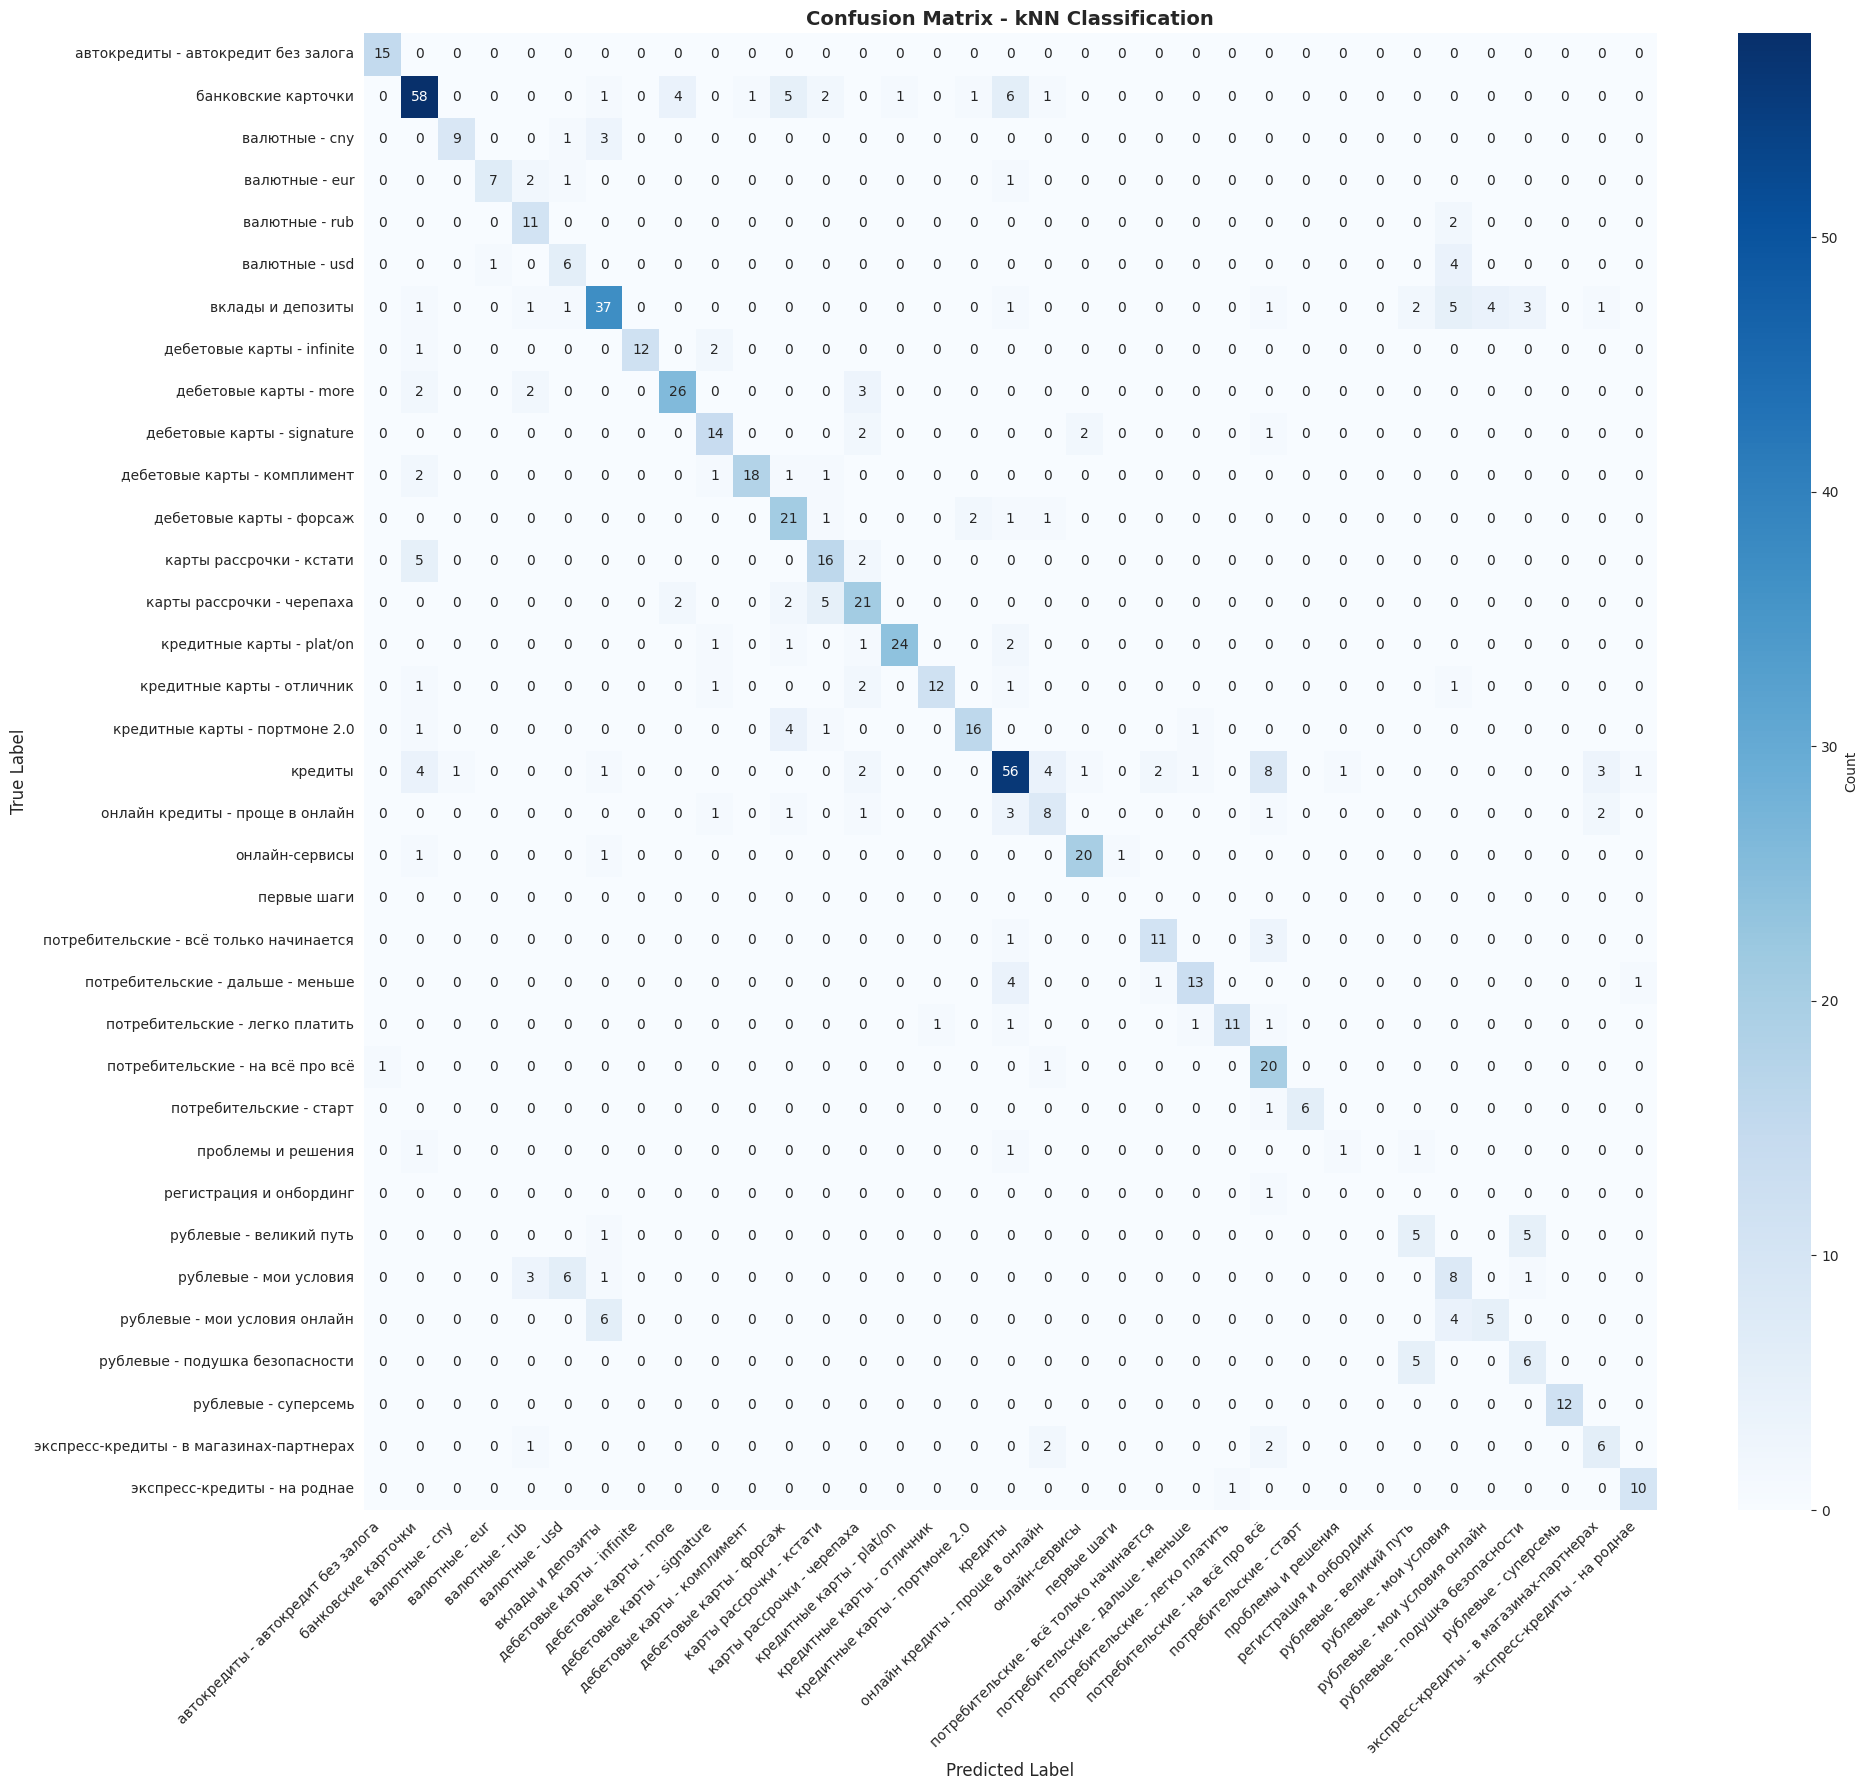

Total classes: 35
Total predictions: 737


In [71]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
unique_labels = sorted(list(set(y_true + y_pred)))

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels, yticklabels=unique_labels,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - kNN Classification', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Total classes: {len(unique_labels)}")
print(f"Total predictions: {len(y_true)}")

In [72]:
# Per-class Performance Analysis
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, 
                                                                   labels=unique_labels,
                                                                   zero_division=0)

# Create a dataframe for easier visualization
performance_df = pd.DataFrame({
    'Class': unique_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}).sort_values('F1-Score', ascending=False)

print("Top 10 best performing classes:")
print(performance_df.head(10).to_string(index=False))
print("\n" + "="*80 + "\n")
print("Top 10 worst performing classes:")
print(performance_df.tail(10).to_string(index=False))

Top 10 best performing classes:
                              Class  Precision   Recall  F1-Score  Support
               рублевые - суперсемь   1.000000 1.000000  1.000000       12
автокредиты - автокредит без залога   0.937500 1.000000  0.967742       15
            потребительские - старт   1.000000 0.857143  0.923077        7
         дебетовые карты - infinite   1.000000 0.800000  0.888889       15
          кредитные карты - plat/on   0.960000 0.827586  0.888889       29
                     онлайн-сервисы   0.869565 0.869565  0.869565       23
       экспресс-кредиты - на роднае   0.833333 0.909091  0.869565       11
       дебетовые карты - комплимент   0.947368 0.782609  0.857143       23
    потребительские - легко платить   0.916667 0.733333  0.814815       15
             дебетовые карты - more   0.812500 0.787879  0.800000       33


Top 10 worst performing classes:
                                   Class  Precision   Recall  F1-Score  Support
экспресс-кредиты - в магазин

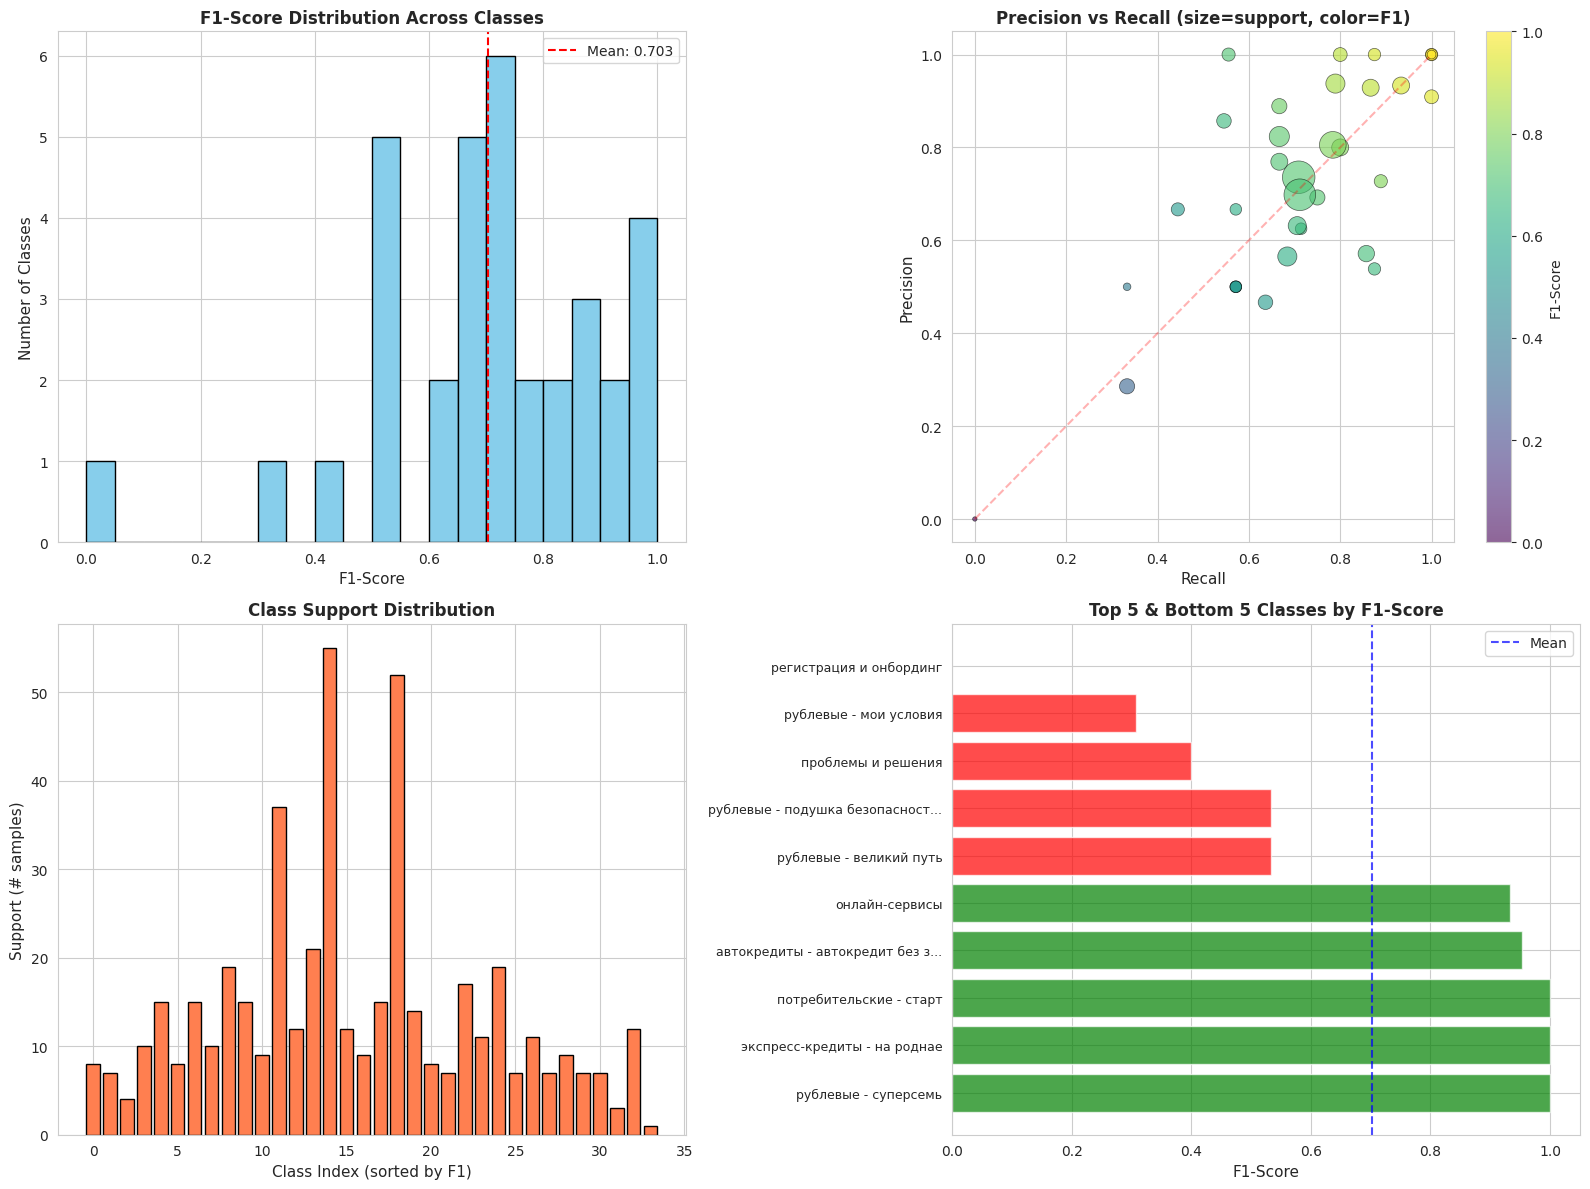

In [17]:
# Visualize per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score distribution
axes[0, 0].hist(performance_df['F1-Score'], bins=20, edgecolor='black', color='skyblue')
axes[0, 0].set_xlabel('F1-Score', fontsize=11)
axes[0, 0].set_ylabel('Number of Classes', fontsize=11)
axes[0, 0].set_title('F1-Score Distribution Across Classes', fontsize=12, fontweight='bold')
axes[0, 0].axvline(performance_df['F1-Score'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {performance_df["F1-Score"].mean():.3f}')
axes[0, 0].legend()

# Precision vs Recall scatter
scatter = axes[0, 1].scatter(performance_df['Recall'], performance_df['Precision'], 
                             s=performance_df['Support']*10, alpha=0.6, c=performance_df['F1-Score'],
                             cmap='viridis', edgecolors='black', linewidth=0.5)
axes[0, 1].set_xlabel('Recall', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision vs Recall (size=support, color=F1)', fontsize=12, fontweight='bold')
axes[0, 1].plot([0, 1], [0, 1], 'r--', alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='F1-Score')

# Support distribution
axes[1, 0].bar(range(len(performance_df)), performance_df['Support'].values, 
               color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Class Index (sorted by F1)', fontsize=11)
axes[1, 0].set_ylabel('Support (# samples)', fontsize=11)
axes[1, 0].set_title('Class Support Distribution', fontsize=12, fontweight='bold')

# Top/Bottom performers comparison
top_bottom = pd.concat([performance_df.head(5), performance_df.tail(5)])
x_pos = range(len(top_bottom))
axes[1, 1].barh(x_pos, top_bottom['F1-Score'], color=['green']*5 + ['red']*5, alpha=0.7)
axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels([c[:30] + '...' if len(c) > 30 else c for c in top_bottom['Class']], 
                            fontsize=9)
axes[1, 1].set_xlabel('F1-Score', fontsize=11)
axes[1, 1].set_title('Top 5 & Bottom 5 Classes by F1-Score', fontsize=12, fontweight='bold')
axes[1, 1].axvline(performance_df['F1-Score'].mean(), color='blue', linestyle='--', 
                    label='Mean', alpha=0.7)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

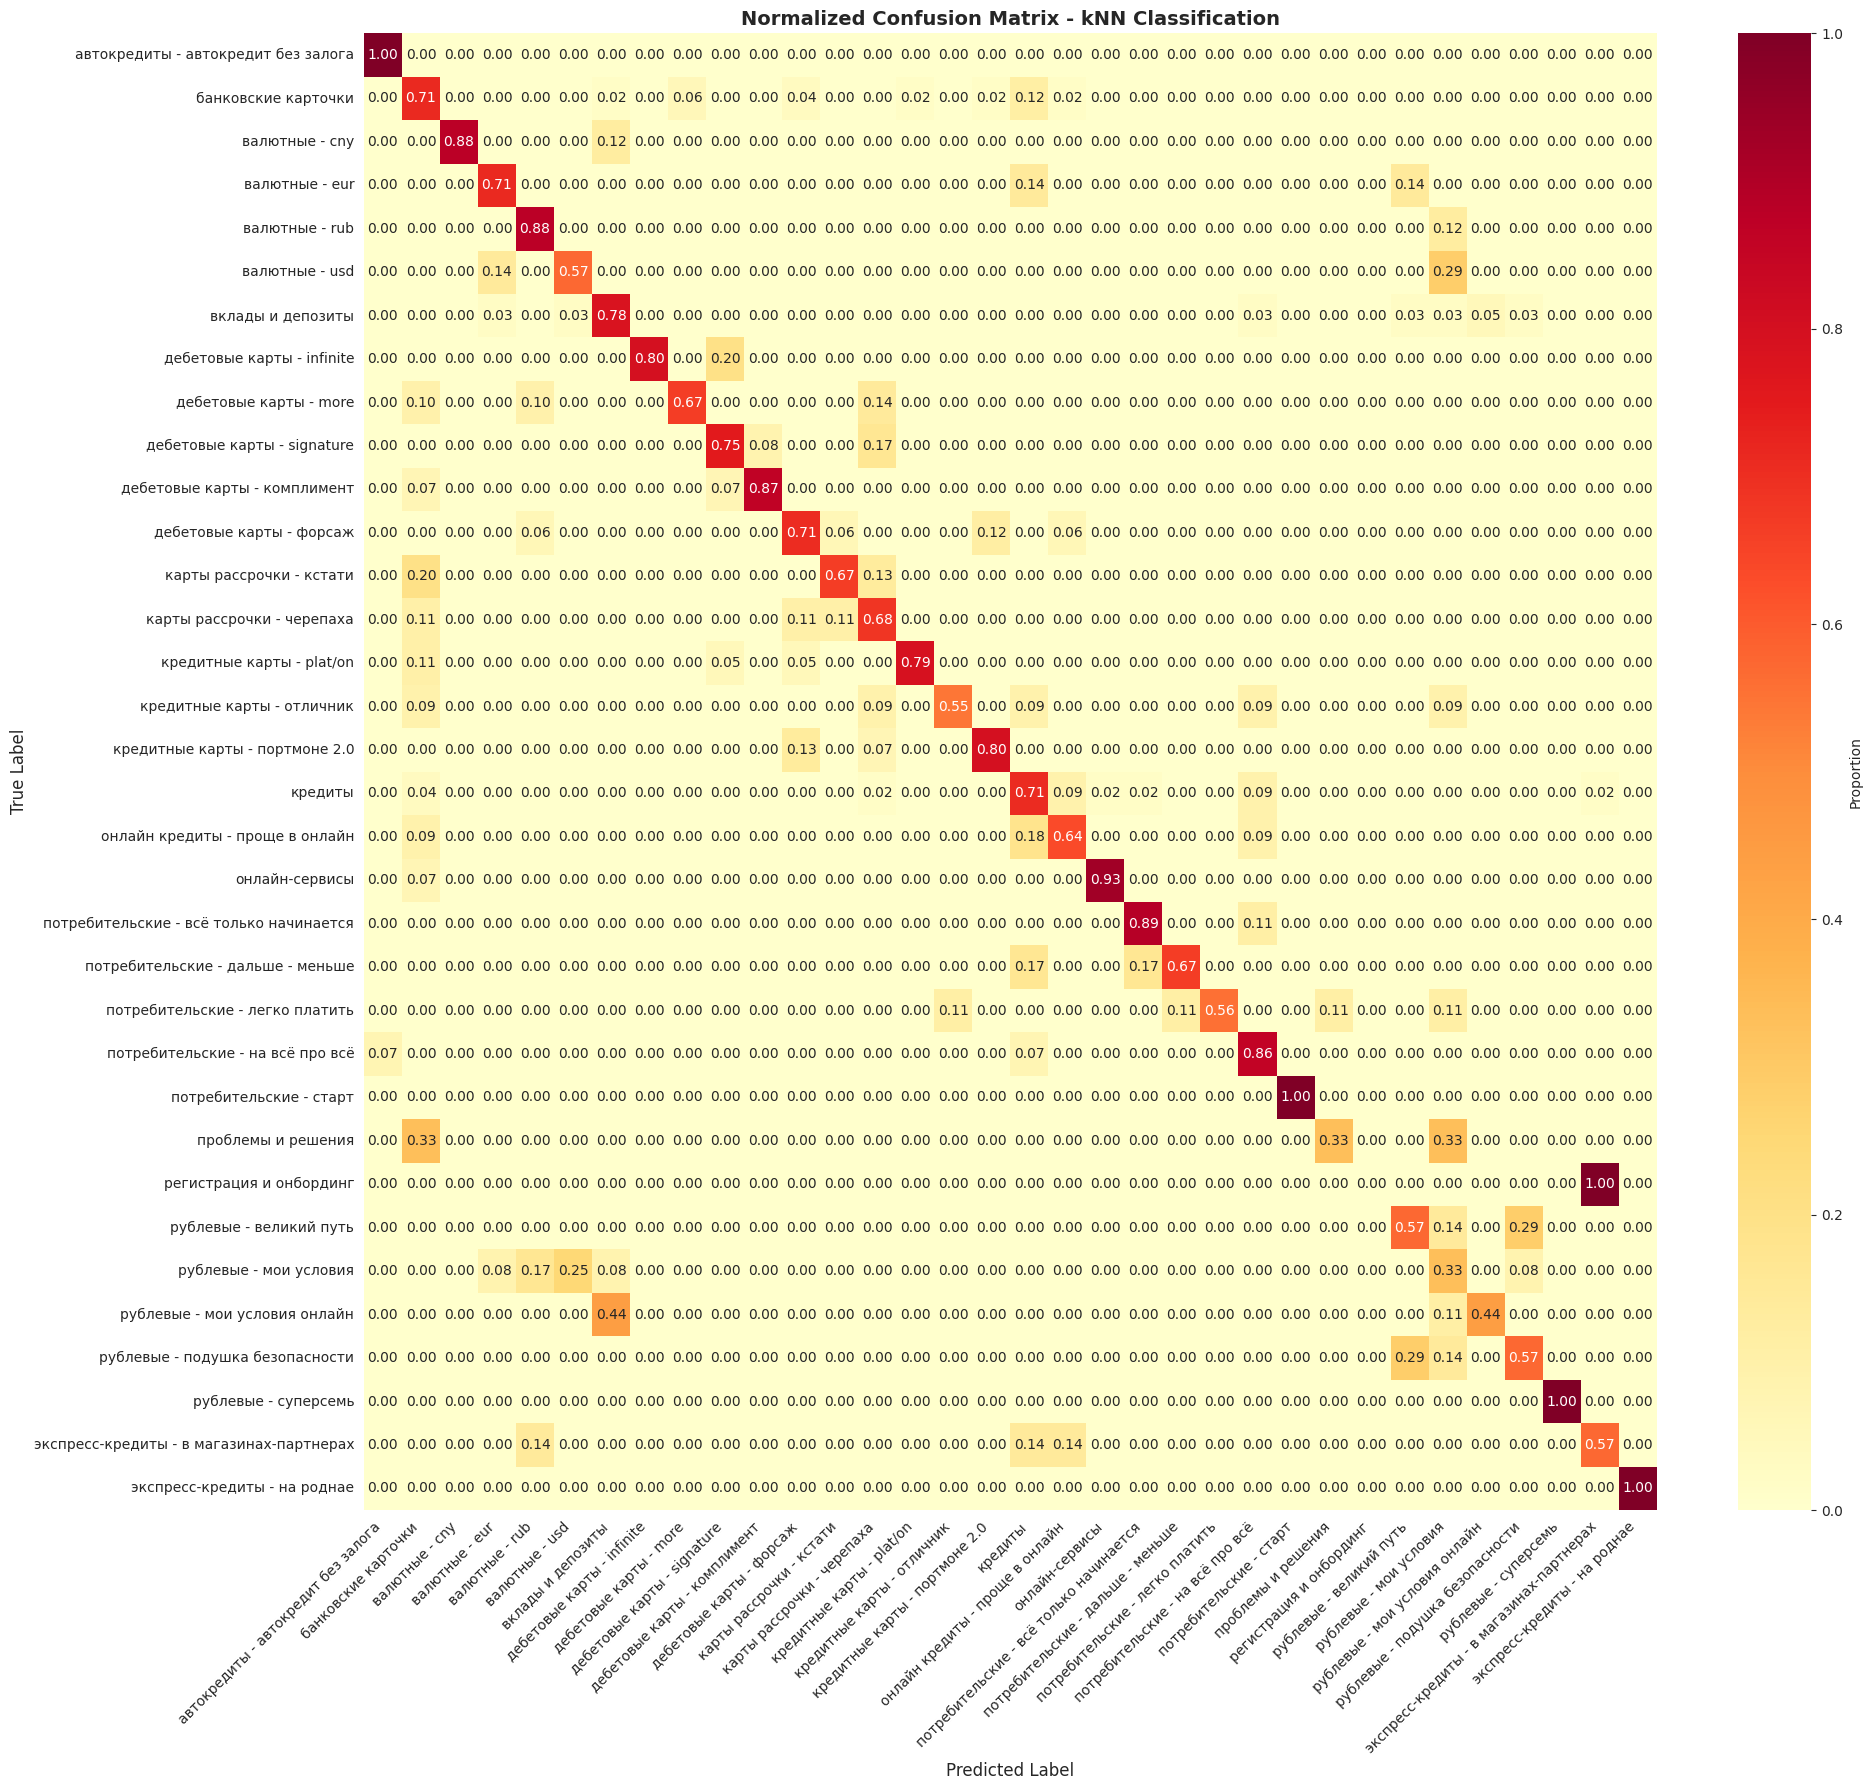

In [18]:
# Normalized Confusion Matrix (showing proportions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 18))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=unique_labels, yticklabels=unique_labels,
            cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Normalized Confusion Matrix - kNN Classification', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
test = "Какая доходность CNY?"
test = normalize_text(test)

emb = get_embeddings_batch_local([test])
emb = l2norm( emb)
dist, idx = knn.kneighbors(emb, return_distance=True)   

In [20]:
y_train_arr = np.array(y_train)
y_pred = y_train_arr[idx[:,0]].tolist()
y_pred

['валютные - cny']

In [106]:
# based_hierarchical_v2.py — Fixed version with true hierarchical training
import polars as pl
import numpy as np
import json
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# ---------- Config ----------
MIN_CLASS_SUPPORT = 5  # Drop classes with fewer samples
PARENT_C = 5.0  # Strong regularization for parent (5 classes)
CHILD_C = 2.0   # Medium regularization for children (7-8 per parent)
ALPHA = 0.25    # Prototype shrinkage (less aggressive)

def l2(a: np.ndarray) -> np.ndarray:
    a = np.asarray(a)
    if a.ndim == 1:
        n = np.linalg.norm(a) + 1e-9
        return a / n
    if a.ndim == 2:
        n = np.linalg.norm(a, axis=1, keepdims=True) + 1e-9
        return a / n
    raise ValueError("l2() expects 1-D or 2-D array")

# ---------- Load and clean data ----------
try:
    y, X, _, _ = get_original_data()
    y_aug, X_aug, _, _ = get_augumented_data()
    
    
    X_aug, X_aug_test, y_aug, y_aug_test = train_test_split(
        X_aug, y_aug, test_size=0.3, random_state=42, stratify=y_aug
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train += X_aug
    y_train += y_aug
    X_test += X_aug_test
    y_test += y_aug_test
    
    print(f"Data sizes -> train: {len(X_train)}, test: {len(X_test)}")
    print(f"Synthetic ratio: {len(y_aug)/(len(y)-len(y_test)):.1f}:1")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# ---------- Load taxonomy ----------
label_desc = pl.read_csv("label_desc.csv")
sub_names_tax = label_desc["subcategory"].map_elements(normalize_text).to_list()
cat_names_tax = label_desc["category"].map_elements(normalize_text).to_list()
label_texts = label_desc["generated_label"].map_elements(normalize_text).to_list()

sub2cat = {s: c for s, c in zip(sub_names_tax, cat_names_tax)}

# ---------- Clean toxic classes ----------
# Count support per class in training data
class_counts = Counter(y_train)
# toxic_classes = {cls for cls, cnt in class_counts.items() if cnt < MIN_CLASS_SUPPORT}

# if toxic_classes:
#     print(f"\n⚠️  Dropping {len(toxic_classes)} classes with <{MIN_CLASS_SUPPORT} samples:")
#     for cls in sorted(toxic_classes):
#         print(f"  - {cls} ({class_counts[cls]} samples)")
    
#     # Remove from train
#     mask_train = np.array([y not in toxic_classes for y in y_train])
#     X_train = [x for x, m in zip(X_train, mask_train) if m]
#     y_train = [y for y, m in zip(y_train, mask_train) if m]
    
#     # Remove from test (for clean evaluation)
#     mask_test = np.array([y not in toxic_classes for y in y_test])
#     X_test = [x for x, m in zip(X_test, mask_test) if m]
#     y_test = [y for y, m in zip(y_test, mask_test) if m]
    
#     # Update taxonomy
#     sub_names_tax = [s for s in sub_names_tax if s not in toxic_classes]
#     cat_names_tax = [c for s, c in zip(label_desc["subcategory"].to_list(), cat_names_tax) 
#                      if normalize_text(s) not in toxic_classes]
#     label_texts = [t for s, t in zip(label_desc["subcategory"].to_list(), label_texts)
#                    if normalize_text(s) not in toxic_classes]
    
#     print(f"Cleaned data -> train: {len(X_train)}, test: {len(X_test)}")

# ---------- Build mappings ----------
sub2id = {name: i for i, name in enumerate(sub_names_tax)}
id2sub = {i: name for name, i in sub2id.items()}

cat2id, id2cat = {}, {}
for name in cat_names_tax:
    if name not in cat2id:
        cid = len(cat2id)
        cat2id[name], id2cat[cid] = cid, name

y_sub_train = np.array([sub2id[s] for s in y_train], dtype=np.int32)
y_cat_train = np.array([cat2id[sub2cat[s]] for s in y_train], dtype=np.int32)

y_sub_test = np.array([sub2id[s] for s in y_test], dtype=np.int32)
y_cat_test = np.array([cat2id[sub2cat[s]] for s in y_test], dtype=np.int32)

parent_map = np.array([cat2id[c] for c in cat_names_tax], dtype=np.int32)

N_SUB = len(sub2id)
N_CAT = len(cat2id)

print(f"\nTaxonomy: {N_SUB} subcategories across {N_CAT} parent categories")

# ---------- Embed ----------
X_train_emb = l2(np.array(X_train))
X_test_emb = l2(np.array(X_test))
desc_vecs = l2(get_embeddings_batch_local(label_texts))

# ---------- Build prototypes (NO DATA LEAKAGE) ----------
def build_protos(X_arr: np.ndarray, y_arr: np.ndarray, desc_vecs: np.ndarray) -> np.ndarray:
    """Build prototypes ONLY from training fold."""
    d = desc_vecs.shape[1]
    protos = np.zeros((N_SUB, d), dtype=np.float32)
    for i in range(N_SUB):
        idx = np.where(y_arr == i)[0]
        if len(idx) > 0:
            base = X_arr[idx].mean(0)
            protos[i] = l2((1 - ALPHA) * base + ALPHA * desc_vecs[i])
        else:
            protos[i] = desc_vecs[i]  # fallback to label text
    return protos

# ---------- Feature engineering ----------
def make_features_v2(x_vec: np.ndarray, protos: np.ndarray, parent_map: np.ndarray) -> np.ndarray:
    """Enhanced features: [sub_sim] + [parent_max] + [parent_mean] + [margin] + [top_parent_margin]"""
    sim_sub = protos @ x_vec
    
    # Parent aggregations
    sim_par_max = np.zeros(N_CAT, dtype=np.float32)
    sim_par_mean = np.zeros(N_CAT, dtype=np.float32)
    for c in range(N_CAT):
        mask = parent_map == c
        if mask.any():
            sim_par_max[c] = sim_sub[mask].max()
            sim_par_mean[c] = sim_sub[mask].mean()
    
    # Margins
    if sim_sub.size >= 2:
        top2 = np.partition(sim_sub, -2)[-2:]
        sub_margin = top2[1] - top2[0]
    else:
        sub_margin = 0.0
    
    if sim_par_max.size >= 2:
        top2_par = np.partition(sim_par_max, -2)[-2:]
        par_margin = top2_par[1] - top2_par[0]
    else:
        par_margin = 0.0
    
    return np.concatenate([sim_sub, sim_par_max, sim_par_mean, [sub_margin, par_margin]]).astype(np.float32)

# ---------- Two-stage hierarchical training ----------
class HierarchicalClassifier:
    def __init__(self, parent_C=5.0, child_C=2.0):
        self.parent_C = parent_C
        self.child_C = child_C
        self.parent_clf = None
        self.child_clfs = {}
        self.parent_scaler = None
        self.child_scalers = {}
        self.protos = None
    
    def fit(self, X_emb, y_sub, y_cat, protos):
        self.protos = protos
        
        # Stage 1: Train parent classifier
        X_feat = np.stack([make_features_v2(x, protos, parent_map) for x in X_emb])
        self.parent_scaler = StandardScaler().fit(X_feat)
        X_scaled = self.parent_scaler.transform(X_feat)
        
        self.parent_clf = LogisticRegression(
            C=self.parent_C, 
            max_iter=3000, 
            class_weight='balanced',
            random_state=42
        )
        self.parent_clf.fit(X_scaled, y_cat)
        
        # Optional: calibrate parent
        # self.parent_clf = CalibratedClassifierCV(self.parent_clf, cv=3, method='isotonic')
        # self.parent_clf.fit(X_scaled, y_cat)
        
        # Stage 2: Train child classifier per parent
        for parent_id in range(N_CAT):
            # Get samples belonging to this parent
            mask = y_cat == parent_id
            if mask.sum() < 2:
                continue
            
            X_parent = X_emb[mask]
            y_parent = y_sub[mask]
            
            # Get child subcategories for this parent
            child_mask = parent_map == parent_id
            child_ids = np.where(child_mask)[0]
            
            if len(child_ids) == 1:
                # Only one child - deterministic
                self.child_clfs[parent_id] = None
                continue
            
            # Build features
            X_feat_child = np.stack([make_features_v2(x, protos, parent_map) for x in X_parent])
            scaler_child = StandardScaler().fit(X_feat_child)
            X_scaled_child = scaler_child.transform(X_feat_child)
            
            # Train child classifier
            clf_child = LogisticRegression(
                C=self.child_C,
                max_iter=3000,
                class_weight='balanced',
                random_state=42
            )
            clf_child.fit(X_scaled_child, y_parent)
            
            self.child_scalers[parent_id] = scaler_child
            self.child_clfs[parent_id] = clf_child
    
    def predict(self, X_emb):
        X_feat = np.stack([make_features_v2(x, self.protos, parent_map) for x in X_emb])
        X_scaled = self.parent_scaler.transform(X_feat)
        
        # Predict parents
        parents_pred = self.parent_clf.predict(X_scaled)
        
        # Predict children
        y_pred = np.zeros(len(X_emb), dtype=np.int32)
        
        for i, parent_id in enumerate(parents_pred):
            child_mask = parent_map == parent_id
            child_ids = np.where(child_mask)[0]
            
            if len(child_ids) == 1:
                # Only one child
                y_pred[i] = child_ids[0]
            elif parent_id in self.child_clfs and self.child_clfs[parent_id] is not None:
                # Use child classifier
                x_feat = make_features_v2(X_emb[i], self.protos, parent_map)
                x_scaled = self.child_scalers[parent_id].transform([x_feat])
                y_pred[i] = self.child_clfs[parent_id].predict(x_scaled)[0]
            else:
                # Fallback: pick child with highest similarity
                sims = self.protos[child_ids] @ X_emb[i]
                y_pred[i] = child_ids[sims.argmax()]
        
        return y_pred
    
    def predict_proba(self, X_emb):
        """Return full probability matrix (for analysis)."""
        X_feat = np.stack([make_features_v2(x, self.protos, parent_map) for x in X_emb])
        X_scaled = self.parent_scaler.transform(X_feat)
        
        parent_probs = self.parent_clf.predict_proba(X_scaled)
        parents_pred = parent_probs.argmax(1)
        
        # Initialize full proba matrix
        probs = np.zeros((len(X_emb), N_SUB), dtype=np.float32)
        
        for i, parent_id in enumerate(parents_pred):
            child_mask = parent_map == parent_id
            child_ids = np.where(child_mask)[0]
            
            if parent_id in self.child_clfs and self.child_clfs[parent_id] is not None:
                x_feat = make_features_v2(X_emb[i], self.protos, parent_map)
                x_scaled = self.child_scalers[parent_id].transform([x_feat])
                child_probs = self.child_clfs[parent_id].predict_proba(x_scaled)[0]
                
                # Map child probs to full matrix
                for j, child_id in enumerate(child_ids):
                    if j < len(child_probs):
                        probs[i, child_id] = parent_probs[i, parent_id] * child_probs[j]
            else:
                # Uniform over children
                probs[i, child_ids] = parent_probs[i, parent_id] / len(child_ids)
        
        return probs

# ---------- Honest CV evaluation ----------
print("\n" + "="*80)
print("5-FOLD CROSS-VALIDATION (NO ABSTENTION FILTERING)")
print("="*80)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro_list, f1_weighted_list = [], []
parent_f1_list = []

for fold, (tr, te) in enumerate(skf.split(X_train_emb, y_sub_train), 1):
    # Build protos on train fold ONLY
    P_fold = build_protos(X_train_emb[tr], y_sub_train[tr], desc_vecs)
    
    # Train hierarchical model
    hier_clf = HierarchicalClassifier(parent_C=PARENT_C, child_C=CHILD_C)
    hier_clf.fit(X_train_emb[tr], y_sub_train[tr], y_cat_train[tr], P_fold)
    
    # Predict on test fold
    y_pred = hier_clf.predict(X_train_emb[te])
    
    # Parent-level F1
    parent_pred = np.array([parent_map[p] for p in y_pred])
    parent_f1 = f1_score(y_cat_train[te], parent_pred, average='weighted')
    parent_f1_list.append(parent_f1)
    
    # Child-level F1
    f1_macro = f1_score(y_sub_train[te], y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_sub_train[te], y_pred, average='weighted', zero_division=0)
    
    f1_macro_list.append(f1_macro)
    f1_weighted_list.append(f1_weighted)
    
    print(f"Fold {fold}: Parent F1={parent_f1:.3f} | Macro F1={f1_macro:.3f} | Weighted F1={f1_weighted:.3f}")

print(f"\n📊 CV Results:")
print(f"  Parent F1:   {np.mean(parent_f1_list):.3f} ± {np.std(parent_f1_list):.3f}")
print(f"  Macro F1:    {np.mean(f1_macro_list):.3f} ± {np.std(f1_macro_list):.3f}")
print(f"  Weighted F1: {np.mean(f1_weighted_list):.3f} ± {np.std(f1_weighted_list):.3f}")

# ---------- Train final model on ALL training data ----------
print("\n" + "="*80)
print("TRAINING FINAL MODEL ON ALL DATA")
print("="*80)

protos_final = build_protos(X_train_emb, y_sub_train, desc_vecs)
final_model = HierarchicalClassifier(parent_C=PARENT_C, child_C=CHILD_C)
final_model.fit(X_train_emb, y_sub_train, y_cat_train, protos_final)

# ---------- Evaluate on held-out test set ----------
print("\n" + "="*80)
print("HELD-OUT TEST SET EVALUATION")
print("="*80)

y_pred_test = final_model.predict(X_test_emb)
parent_pred_test = np.array([parent_map[p] for p in y_pred_test])

print(f"Parent Accuracy: {(parent_pred_test == y_cat_test).mean():.3f}")
print(f"Parent F1 (weighted): {f1_score(y_cat_test, parent_pred_test, average='weighted'):.3f}")
print(f"\nSubcategory Accuracy: {(y_pred_test == y_sub_test).mean():.3f}")
print(f"Subcategory Macro F1: {f1_score(y_sub_test, y_pred_test, average='macro', zero_division=0):.3f}")
print(f"Subcategory Weighted F1: {f1_score(y_sub_test, y_pred_test, average='weighted', zero_division=0):.3f}")

# Detailed report
print("\n" + "="*80)
print("PER-CLASS REPORT")
print("="*80)
report = classification_report(y_sub_test, y_pred_test, target_names=[id2sub[i] for i in range(N_SUB)], 
                                zero_division=0, output_dict=True)
import pandas as pd
df_report = pd.DataFrame(report).T
df_report = df_report[df_report['support'] > 0].sort_values('f1-score', ascending=False)

print("\nTop 10 classes:")
print(df_report.head(10)[['precision', 'recall', 'f1-score', 'support']].to_string())

print("\nBottom 10 classes:")
print(df_report.tail(10)[['precision', 'recall', 'f1-score', 'support']].to_string())

# ---------- Production inference helper ----------
def predict_ticket_fixed(text: str):
    """Fixed inference with no data leakage."""
    emb = l2(get_embeddings_batch_local([text])[0])
    pred_id = final_model.predict(np.array([emb]))[0]
    probs = final_model.predict_proba(np.array([emb]))[0]
    
    top3_ids = probs.argsort()[-3:][::-1]
    parent_id = parent_map[pred_id]
    
    return {
        'parent_name': id2cat[parent_id],
        'subcat_id': int(pred_id),
        'subcat_name': id2sub[pred_id],
        'confidence': float(probs[pred_id]),
        'top3_ids': [int(i) for i in top3_ids],
        'top3_names': [id2sub[i] for i in top3_ids],
        'top3_scores': [float(probs[i]) for i in top3_ids],
    }

# Save model
import pickle
with open('hierarchical_model_v2.pkl', 'wb') as f:
    pickle.dump({
        'model': final_model,
        'protos': protos_final,
        'sub2id': sub2id,
        'id2sub': id2sub,
        'cat2id': cat2id,
        'id2cat': id2cat,
        'parent_map': parent_map
    }, f)

print("\n✅ Model saved to hierarchical_model_v2.pkl")


Augmented data size: 1054
Data sizes -> train: 897, test: 358
Synthetic ratio: -4.7:1

Taxonomy: 35 subcategories across 6 parent categories

5-FOLD CROSS-VALIDATION (NO ABSTENTION FILTERING)
Fold 1: Parent F1=0.879 | Macro F1=0.661 | Weighted F1=0.711
Fold 2: Parent F1=0.828 | Macro F1=0.703 | Weighted F1=0.719
Fold 3: Parent F1=0.866 | Macro F1=0.701 | Weighted F1=0.745
Fold 4: Parent F1=0.800 | Macro F1=0.680 | Weighted F1=0.704
Fold 5: Parent F1=0.816 | Macro F1=0.625 | Weighted F1=0.683

📊 CV Results:
  Parent F1:   0.838 ± 0.030
  Macro F1:    0.674 ± 0.029
  Weighted F1: 0.712 ± 0.020

TRAINING FINAL MODEL ON ALL DATA

HELD-OUT TEST SET EVALUATION
Parent Accuracy: 0.835
Parent F1 (weighted): 0.834

Subcategory Accuracy: 0.729
Subcategory Macro F1: 0.717
Subcategory Weighted F1: 0.731

PER-CLASS REPORT


ValueError: Number of classes, 34, does not match size of target_names, 35. Try specifying the labels parameter

In [96]:
# unified_reranker.py - Category-constrained retrieval for any classifier


from typing import Protocol, Optional
import numpy as np
from collections import defaultdict

class ClassifierProtocol(Protocol):
    """Interface any classifier must implement."""
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Return predicted category IDs."""
        ...
    
    def predict_proba(self, X: np.ndarray) -> Optional[np.ndarray]:
        """Return prediction probabilities (optional)."""
        ...


class UnifiedRetriever:
    """
    Universal retrieval system that works with any classifier.
    
    Key insight: Classification narrows search space, 
    then we match query embedding to ANSWER embeddings.
    """
    def __init__(
        self,
        classifier: ClassifierProtocol,
        parent_map: np.ndarray,
        train_query_embs: np.ndarray,      # Query embeddings (for kNN fallback)
        train_answer_embs: np.ndarray,     # Answer embeddings (for retrieval)
        train_labels: np.ndarray,          # Category labels
        train_answers: list[str],          # Answer texts
        conf_thresholds: tuple[float, float] = (0.65, 0.50),
        use_answer_embs: bool = True       # If False, use query embeddings (old behavior)
    ):
        self.clf = classifier
        self.parent_map = parent_map
        self.conf_thresholds = conf_thresholds
        self.use_answer_embs = use_answer_embs
        
        # Decide which embeddings to use for retrieval
        self.retrieval_embs = train_answer_embs if use_answer_embs else train_query_embs
        
        print(f"🔍 Retrieval mode: {'Answer embeddings' if use_answer_embs else 'Query embeddings'}")
        
        # Build indices by category
        self.subcat_index = defaultdict(lambda: {'embs': [], 'answers': [], 'indices': []})
        self.parent_index = defaultdict(lambda: {'embs': [], 'answers': [], 'indices': []})
        self.global_index = {
            'embs': self.retrieval_embs,
            'answers': train_answers,
            'labels': train_labels
        }
        
        for idx, (emb, answer, label) in enumerate(zip(self.retrieval_embs, train_answers, train_labels)):
            parent_id = parent_map[label]
            
            # Index by subcategory
            self.subcat_index[label]['embs'].append(emb)
            self.subcat_index[label]['answers'].append(answer)
            self.subcat_index[label]['indices'].append(idx)
            
            # Index by parent category
            self.parent_index[parent_id]['embs'].append(emb)
            self.parent_index[parent_id]['answers'].append(answer)
            self.parent_index[parent_id]['indices'].append(idx)
        
        # Convert to numpy
        for label in self.subcat_index:
            self.subcat_index[label]['embs'] = np.array(self.subcat_index[label]['embs'])
        
        for parent_id in self.parent_index:
            self.parent_index[parent_id]['embs'] = np.array(self.parent_index[parent_id]['embs'])
        
        print(f"✅ Indexed {len(train_answers)} training examples")
        print(f"   - {len(self.subcat_index)} subcategories")
        print(f"   - {len(self.parent_index)} parent categories")
    
    def _get_confidence(self, query_emb: np.ndarray, predicted_label: int) -> dict:
        """Extract confidence from classifier (works with any classifier)."""
        try:
            # Try to get probabilities
            probs = self.clf.predict_proba(query_emb.reshape(1, -1))
            if probs is not None:
                parent_id = self.parent_map[predicted_label]
                
                # For hierarchical: extract parent and child confidence
                if hasattr(self.clf, 'predict_with_meta'):
                    meta = self.clf.predict_with_meta(query_emb.reshape(1, -1))
                    return {
                        'parent_id': meta['parent_id'],
                        'parent_conf': meta['parent_confidence'],
                        'child_conf': meta['child_confidence']
                    }
                else:
                    # For flat classifiers: use predicted class probability
                    conf = probs[0, predicted_label]
                    return {
                        'parent_id': parent_id,
                        'parent_conf': conf,
                        'child_conf': conf
                    }
        except:
            pass
        
        # Fallback: no confidence available
        return {
            'parent_id': self.parent_map[predicted_label],
            'parent_conf': 0.5,
            'child_conf': 0.5
        }
    
    def retrieve(self, query_emb: np.ndarray, top_k: int = 1, return_metadata: bool = False) -> dict | list[dict]:
        """
        Retrieve top-k answers for query.
        
        Args:
            query_emb: Query embedding (1024-dim)
            top_k: Number of answers to return
            return_metadata: Include debug info
        
        Returns:
            Single dict (if top_k=1) or list of dicts with:
                - answer: Answer text
                - similarity: Cosine similarity score
                - search_scope: 'subcategory' | 'parent' | 'global'
                - confidence: Classification confidence
        """
        # Predict category
        predicted_label = self.clf.predict(query_emb.reshape(1, -1))[0]
        
        # Get confidence
        conf_info = self._get_confidence(query_emb, predicted_label)
        parent_conf = conf_info['parent_conf']
        child_conf = conf_info['child_conf']
        parent_id = conf_info['parent_id']
        
        # Decide search scope based on confidence
        subcat_thresh, parent_thresh = self.conf_thresholds
        
        if child_conf > subcat_thresh and predicted_label in self.subcat_index:
            # HIGH confidence → search within predicted subcategory
            scope = 'subcategory'
            candidate_embs = self.subcat_index[predicted_label]['embs']
            candidate_answers = self.subcat_index[predicted_label]['answers']
        
        elif parent_conf > parent_thresh and parent_id in self.parent_index:
            # MEDIUM confidence → search within parent category
            scope = 'parent'
            candidate_embs = self.parent_index[parent_id]['embs']
            candidate_answers = self.parent_index[parent_id]['answers']
        
        else:
            # LOW confidence → global search
            scope = 'global'
            candidate_embs = self.global_index['embs']
            candidate_answers = self.global_index['answers']
        
        # Compute similarities to ANSWER embeddings
        similarities = candidate_embs @ query_emb.flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        
        results = []
        for rank, idx in enumerate(top_indices):
            result = {
                'answer': candidate_answers[idx],
                'similarity': float(similarities[idx]),
                'rank': rank + 1
            }
            
            if return_metadata:
                result['metadata'] = {
                    'search_scope': scope,
                    'num_candidates': len(candidate_answers),
                    'parent_confidence': parent_conf,
                    'child_confidence': child_conf,
                    'predicted_label': predicted_label,
                    'predicted_parent': parent_id
                }
            
            results.append(result)
        
        return results[0] if top_k == 1 else results
    
    def evaluate(self, X_test: np.ndarray, y_test_answers: list[str], 
                 y_test_labels: list[int] = None, verbose: bool = True) -> dict:
        """
        Evaluate retrieval accuracy.
        
        FIXED: Use both answer text matching AND category label matching.
        
        Args:
            X_test: Test query embeddings
            y_test_answers: Ground truth answer texts
            y_test_labels: Ground truth category labels (optional, for category accuracy)
            verbose: Print detailed results
        """
        top1_correct = 0
        top3_correct = 0
        reciprocal_ranks = []
        
        # Also track category accuracy (if labels provided)
        category_correct = 0 if y_test_labels is not None else None
        
        scope_counts = defaultdict(int)
        scope_correct = defaultdict(int)
        
        for i, (query_emb, true_answer) in enumerate(zip(X_test, y_test_answers)):
            # Get top-3 predictions
            results = self.retrieve(query_emb, top_k=3, return_metadata=True)
            
            scope = results[0]['metadata']['search_scope']
            scope_counts[scope] += 1
            
            # Check if correct answer is in top-k
            predicted_answers = [r['answer'] for r in results]
            
            # Method 1: Exact string match (strict)
            if predicted_answers[0] == true_answer:
                top1_correct += 1
                scope_correct[scope] += 1
                reciprocal_ranks.append(1.0)
            elif true_answer in predicted_answers:
                top3_correct += 1
                rank = predicted_answers.index(true_answer) + 1
                reciprocal_ranks.append(1.0 / rank)
            else:
                reciprocal_ranks.append(0.0)
            
            # Method 2: Category match (if labels provided)
            if y_test_labels is not None:
                predicted_label = results[0]['metadata']['predicted_label']
                true_label = y_test_labels[i]
                if predicted_label == true_label:
                    category_correct += 1
        
        n_test = len(X_test)
        mrr = np.mean(reciprocal_ranks)
        
        if verbose:
            print(f"\n📊 Retrieval Evaluation:")
            print(f"  Top-1 Answer Accuracy: {top1_correct/n_test:.3f} ({top1_correct}/{n_test})")
            print(f"  Top-3 Answer Accuracy: {(top1_correct + top3_correct)/n_test:.3f}")
            print(f"  Mean Reciprocal Rank:  {mrr:.3f}")
            
            if category_correct is not None:
                print(f"  Category Accuracy:     {category_correct/n_test:.3f} (classification correctness)")
            
            print(f"\n  Search Scope Breakdown:")
            for scope in ['subcategory', 'parent', 'global']:
                if scope in scope_counts:
                    count = scope_counts[scope]
                    correct = scope_correct[scope]
                    print(f"    {scope:12s}: {count:3d} queries ({count/n_test*100:5.1f}%) → {correct/count:.3f} accuracy")
            
            # Debug: Show some examples where retrieval failed
            print(f"\n  🔍 Sample failures (first 3):")
            failures_shown = 0
            for i, (query_emb, true_answer) in enumerate(zip(X_test, y_test_answers)):
                if failures_shown >= 3:
                    break
                
                results = self.retrieve(query_emb, top_k=1, return_metadata=False)
                if results[0]['answer'] != true_answer:
                    print(f"\n    Query {i}:")
                    print(f"      True:      {true_answer[:80]}...")
                    print(f"      Predicted: {results[0]['answer'][:80]}...")
                    print(f"      Similarity: {results[0]['similarity']:.3f}")
                    failures_shown += 1
        
        return {
            'top1_accuracy': top1_correct / n_test,
            'top3_accuracy': (top1_correct + top3_correct) / n_test,
            'mrr': mrr,
            'category_accuracy': category_correct / n_test if category_correct is not None else None,
            'scope_breakdown': {
                scope: {'count': scope_counts[scope], 'accuracy': scope_correct[scope] / scope_counts[scope]}
                for scope in scope_counts
            }
        }


In [103]:
# diagnostic_fix.py - Find and fix the mismatch

print("="*80)
print("DIAGNOSTIC: CHECK DATA LENGTHS")
print("="*80)

# Check all data lengths
print(f"\nData shapes:")
print(f"  E_test:        {E_test.shape}")
print(f"  y_test:        {len(y_test)} (type: {type(y_test).__name__})")
print(f"  answers_test:  {len(answers_test)} (type: {type(answers_test).__name__})")
print(f"  y_test_ids:    {len(y_test_ids)} (type: {type(y_test_ids).__name__})")

# CRITICAL: Verify alignment
if not (len(E_test) == len(y_test) == len(answers_test) == len(y_test_ids)):
    print("\n❌ DATA LENGTH MISMATCH DETECTED!")
    print("   This will cause IndexError in evaluation")
    
    # Find the mismatch
    lengths = {
        'E_test': len(E_test),
        'y_test': len(y_test),
        'answers_test': len(answers_test),
        'y_test_ids': len(y_test_ids)
    }
    
    max_len = max(lengths.values())
    min_len = min(lengths.values())
    
    print(f"\n   Expected length: {min_len}")
    for name, length in lengths.items():
        status = "✅" if length == min_len else "❌"
        print(f"   {status} {name}: {length}")
    
    # TRUNCATE to shortest length
    shortest = min(len(E_test), len(y_test), len(answers_test), len(y_test_ids))
    
    print(f"\n🔧 Fixing: Truncating all to {shortest} samples")
    
    E_test = E_test[:shortest]
    y_test = y_test[:shortest]
    
    # Handle answers_test (might be list or array)
    if isinstance(answers_test, np.ndarray):
        answers_test = answers_test[:shortest].tolist()
    else:
        answers_test = answers_test[:shortest]
    
    y_test_ids = y_test_ids[:shortest]
    
    print(f"✅ All data aligned to {shortest} samples")

else:
    print("\n✅ All data lengths match")

# Re-verify
print(f"\n📊 Final data shapes:")
print(f"  E_test:        {E_test.shape}")
print(f"  y_test:        {len(y_test)}")
print(f"  answers_test:  {len(answers_test)}")
print(f"  y_test_ids:    {len(y_test_ids)}")


DIAGNOSTIC: CHECK DATA LENGTHS

Data shapes:
  E_test:        (420, 1024)
  y_test:        420 (type: list)
  answers_test:  420 (type: ndarray)
  y_test_ids:    357 (type: ndarray)

❌ DATA LENGTH MISMATCH DETECTED!
   This will cause IndexError in evaluation

   Expected length: 357
   ❌ E_test: 420
   ❌ y_test: 420
   ❌ answers_test: 420
   ✅ y_test_ids: 357

🔧 Fixing: Truncating all to 357 samples
✅ All data aligned to 357 samples

📊 Final data shapes:
  E_test:        (357, 1024)
  y_test:        357
  answers_test:  357
  y_test_ids:    357


In [98]:
# integration_hierarchical_fixed.py - Complete working pipeline

print("="*80)
print("HIERARCHICAL CLASSIFIER + ANSWER RETRIEVAL (FIXED)")
print("="*80)

# Train hierarchical classifier
protos_final = build_protos(X_train_emb, y_sub_train, desc_vecs)
final_model = HierarchicalClassifier(parent_C=PARENT_C, child_C=CHILD_C)
final_model.fit(X_train_emb, y_sub_train, y_cat_train, protos_final)

print("\n✅ Classifier trained")

# Create retriever
retriever_hierarchical = CategoryConstrainedRetriever(
    classifier=final_model,
    parent_map=parent_map,
    train_query_embs=E_train,  # Query embeddings
    train_answer_embs=E_answers_train,  # Answer embeddings
    train_labels=y_sub_train,  # Integer category IDs
    train_answers=answers_train,  # Answer texts (as list)
    conf_thresholds=(0.65, 0.50),
    use_answer_embs=True
)

# Evaluate with category labels
print("\n" + "="*80)
print("EVALUATION")
print("="*80)

# Convert test labels to integers
y_test_ids = np.array([sub2id[y] for y in y_test])

retrieval_results = retriever_hierarchical.evaluate(
    X_test=E_test,  # Test query embeddings
    y_test_answers=answers_test,  # Test answer texts
    y_test_labels=y_test_ids,  # Test category IDs (for verification)
    verbose=True
)

# Demo
print("\n" + "="*80)
print("DEMO INFERENCE")
print("="*80)

demo_text = "хочу взять кредит на машину"
demo_emb = l2(get_embeddings_batch_local([demo_text])[0])

result = retriever_hierarchical.retrieve(demo_emb, top_k=3, return_metadata=True)

print(f"\n{'='*60}")
print(f"Query: {demo_text}")
print(f"{'='*60}")
print(f"\n✅ Top Answer:")
print(f"   {result[0]['answer'][:300]}...")
print(f"\n📊 Metadata:")
print(f"   Similarity: {result[0]['similarity']:.3f}")
print(f"   Search Scope: {result[0]['metadata']['search_scope']}")
print(f"   Candidates Searched: {result[0]['metadata']['num_candidates']}")
print(f"   Classification Confidence: parent={result[0]['metadata']['parent_confidence']:.3f}, "
      f"child={result[0]['metadata']['child_confidence']:.3f}")
print(f"\n📋 Alternative Answers:")
for i, alt in enumerate(result[1:], 2):
    print(f"   {i}. {alt['answer'][:150]}... (similarity: {alt['similarity']:.3f})")


HIERARCHICAL CLASSIFIER + ANSWER RETRIEVAL (FIXED)

✅ Classifier trained
🔍 Retrieval mode: Answer embeddings
✅ Indexed 835 training examples
   - 33 subcategories
   - 5 parent categories

EVALUATION


IndexError: index 357 is out of bounds for axis 0 with size 357

COMPREHENSIVE MODEL ANALYSIS

CONFIDENCE ANALYSIS


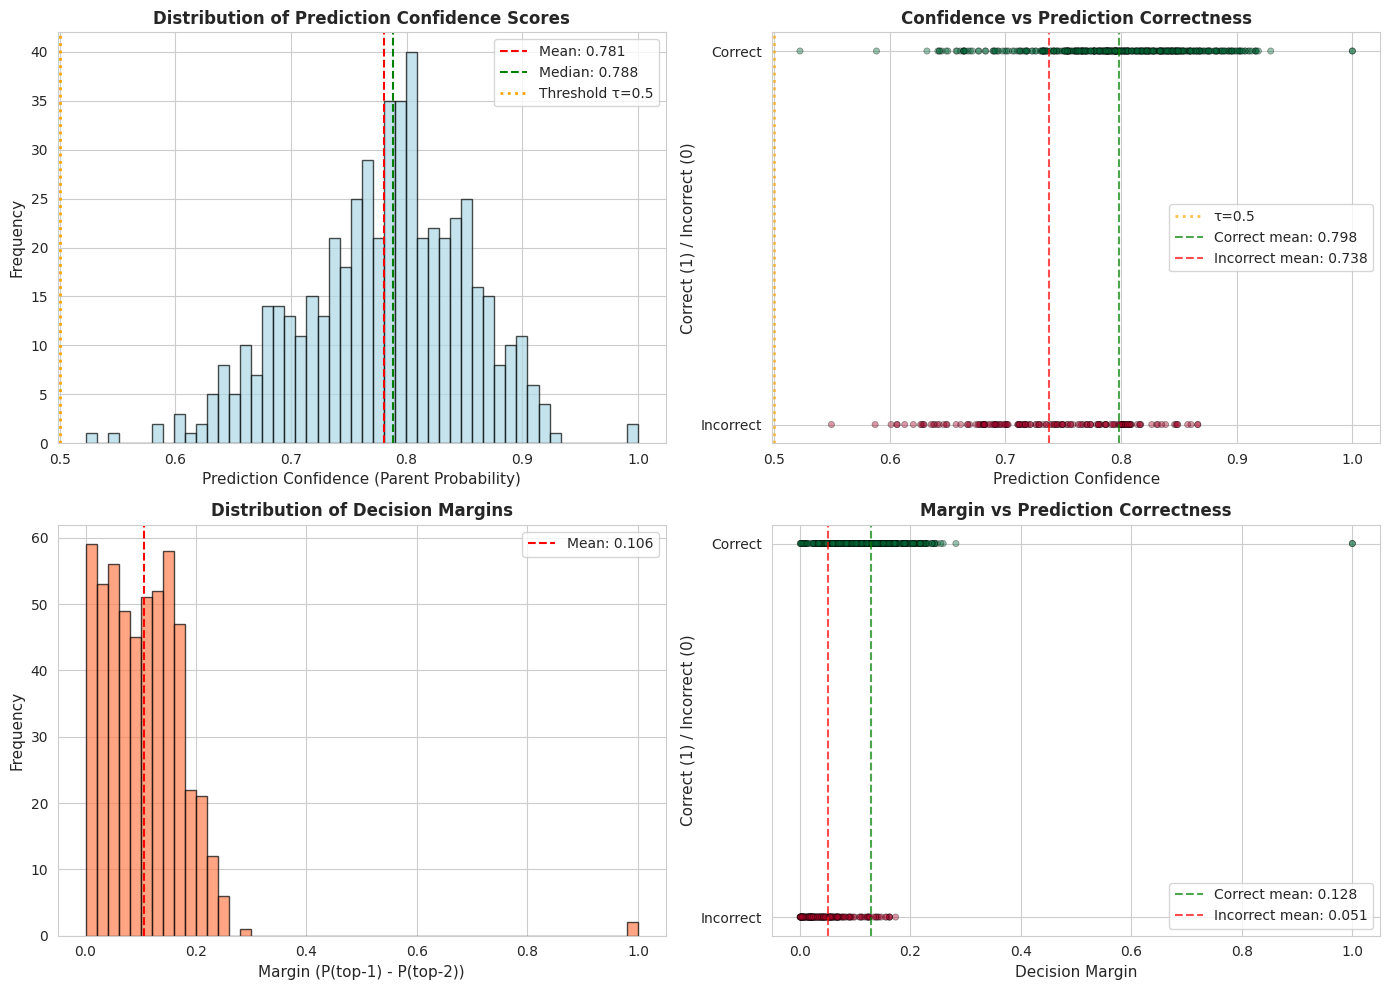


Confidence Statistics:
  Mean confidence (correct):   0.7982
  Mean confidence (incorrect): 0.7381
  Mean margin (correct):       0.1280
  Mean margin (incorrect):     0.0515
  Predictions above threshold: 534 (100.00%)
  Routed to default:           19 (3.56%)

TOP-K ACCURACY ANALYSIS


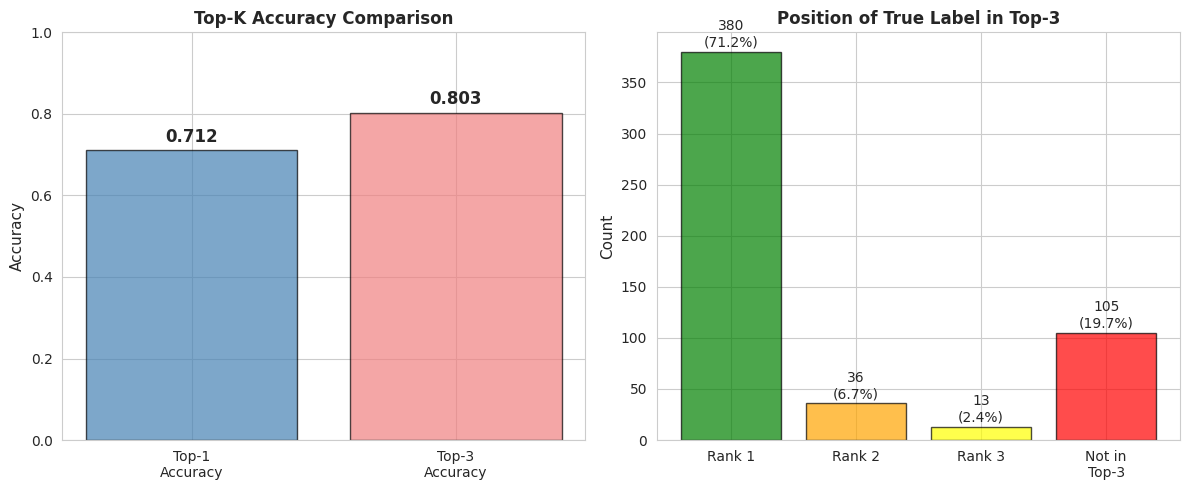


Top-K Accuracy:
  Top-1: 0.7116 (380/534)
  Top-3: 0.8034 (429/534)

True label position:
  Rank 1: 380 (71.16%)
  Rank 2: 36 (6.74%)
  Rank 3: 13 (2.43%)
  Not in top-3: 105 (19.66%)

CALIBRATION ANALYSIS


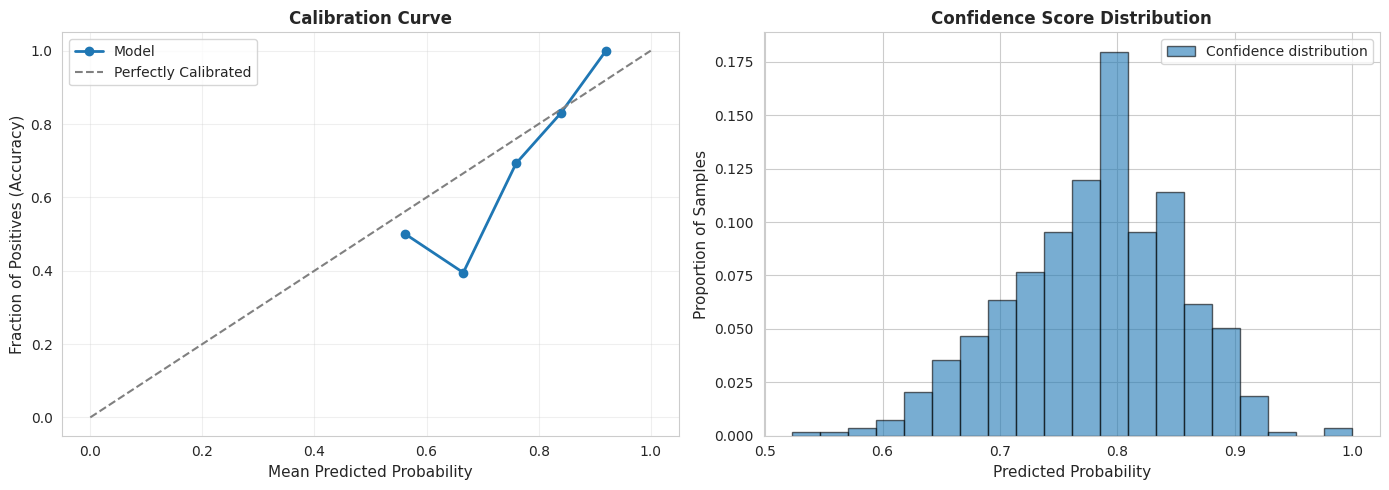


Expected Calibration Error (ECE): 0.0980
(Lower is better - 0 is perfect)

CONFUSION MATRIX


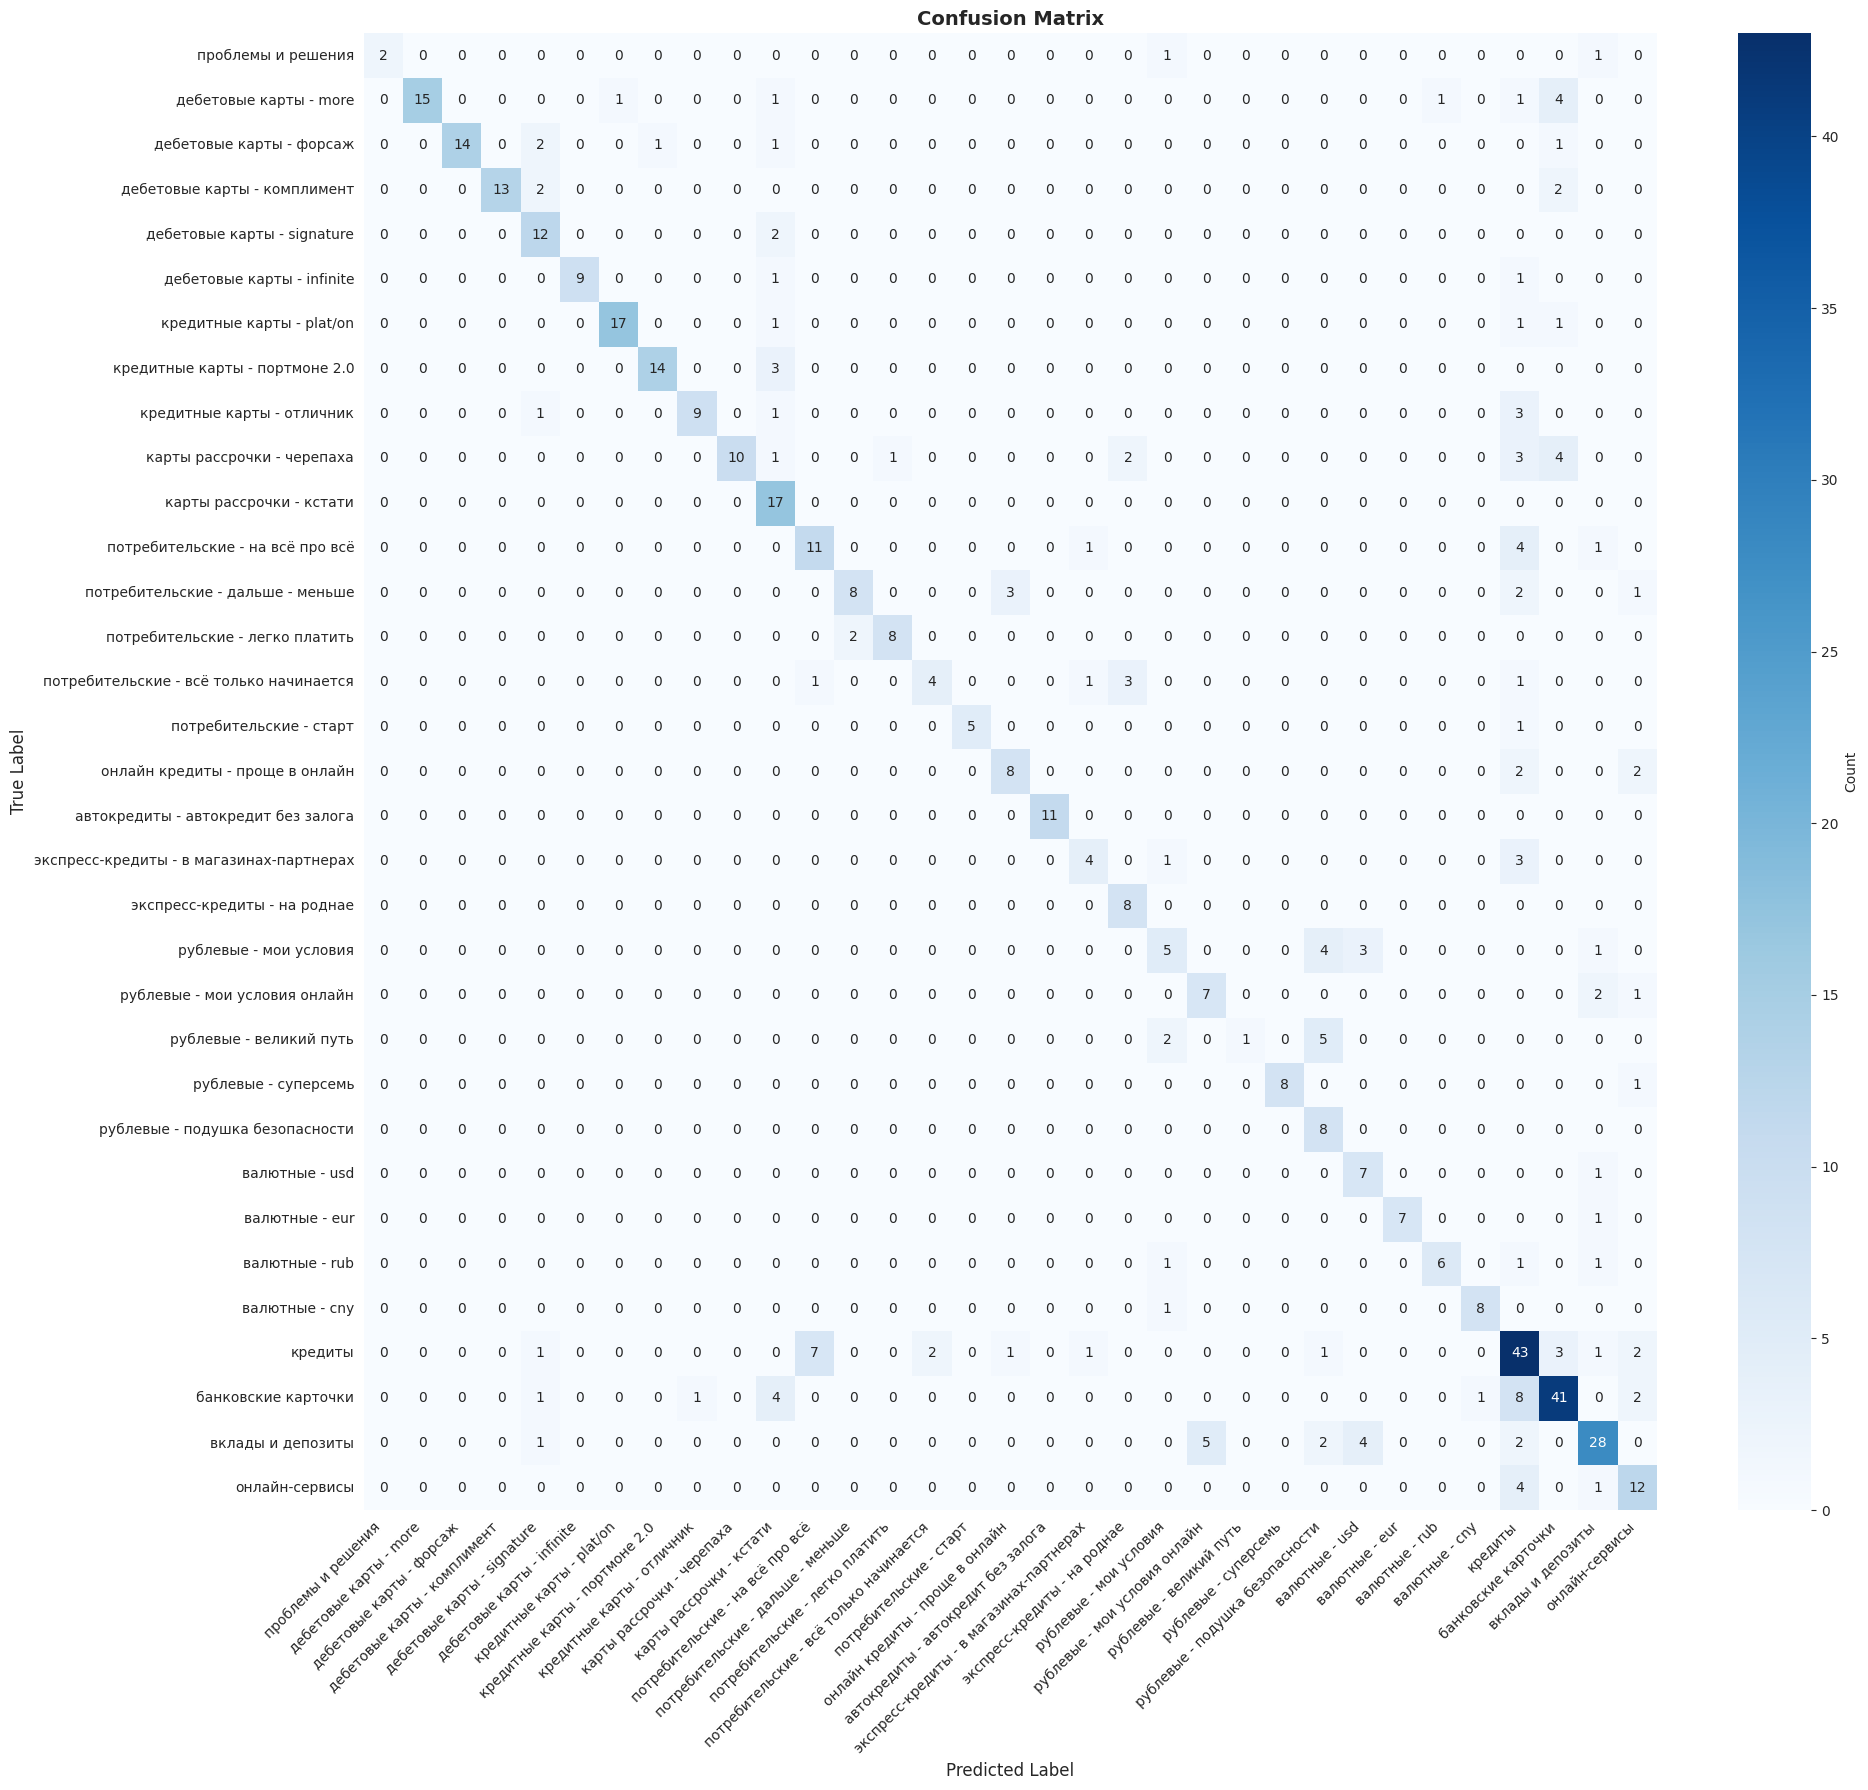


Total classes: 33
Total predictions: 534


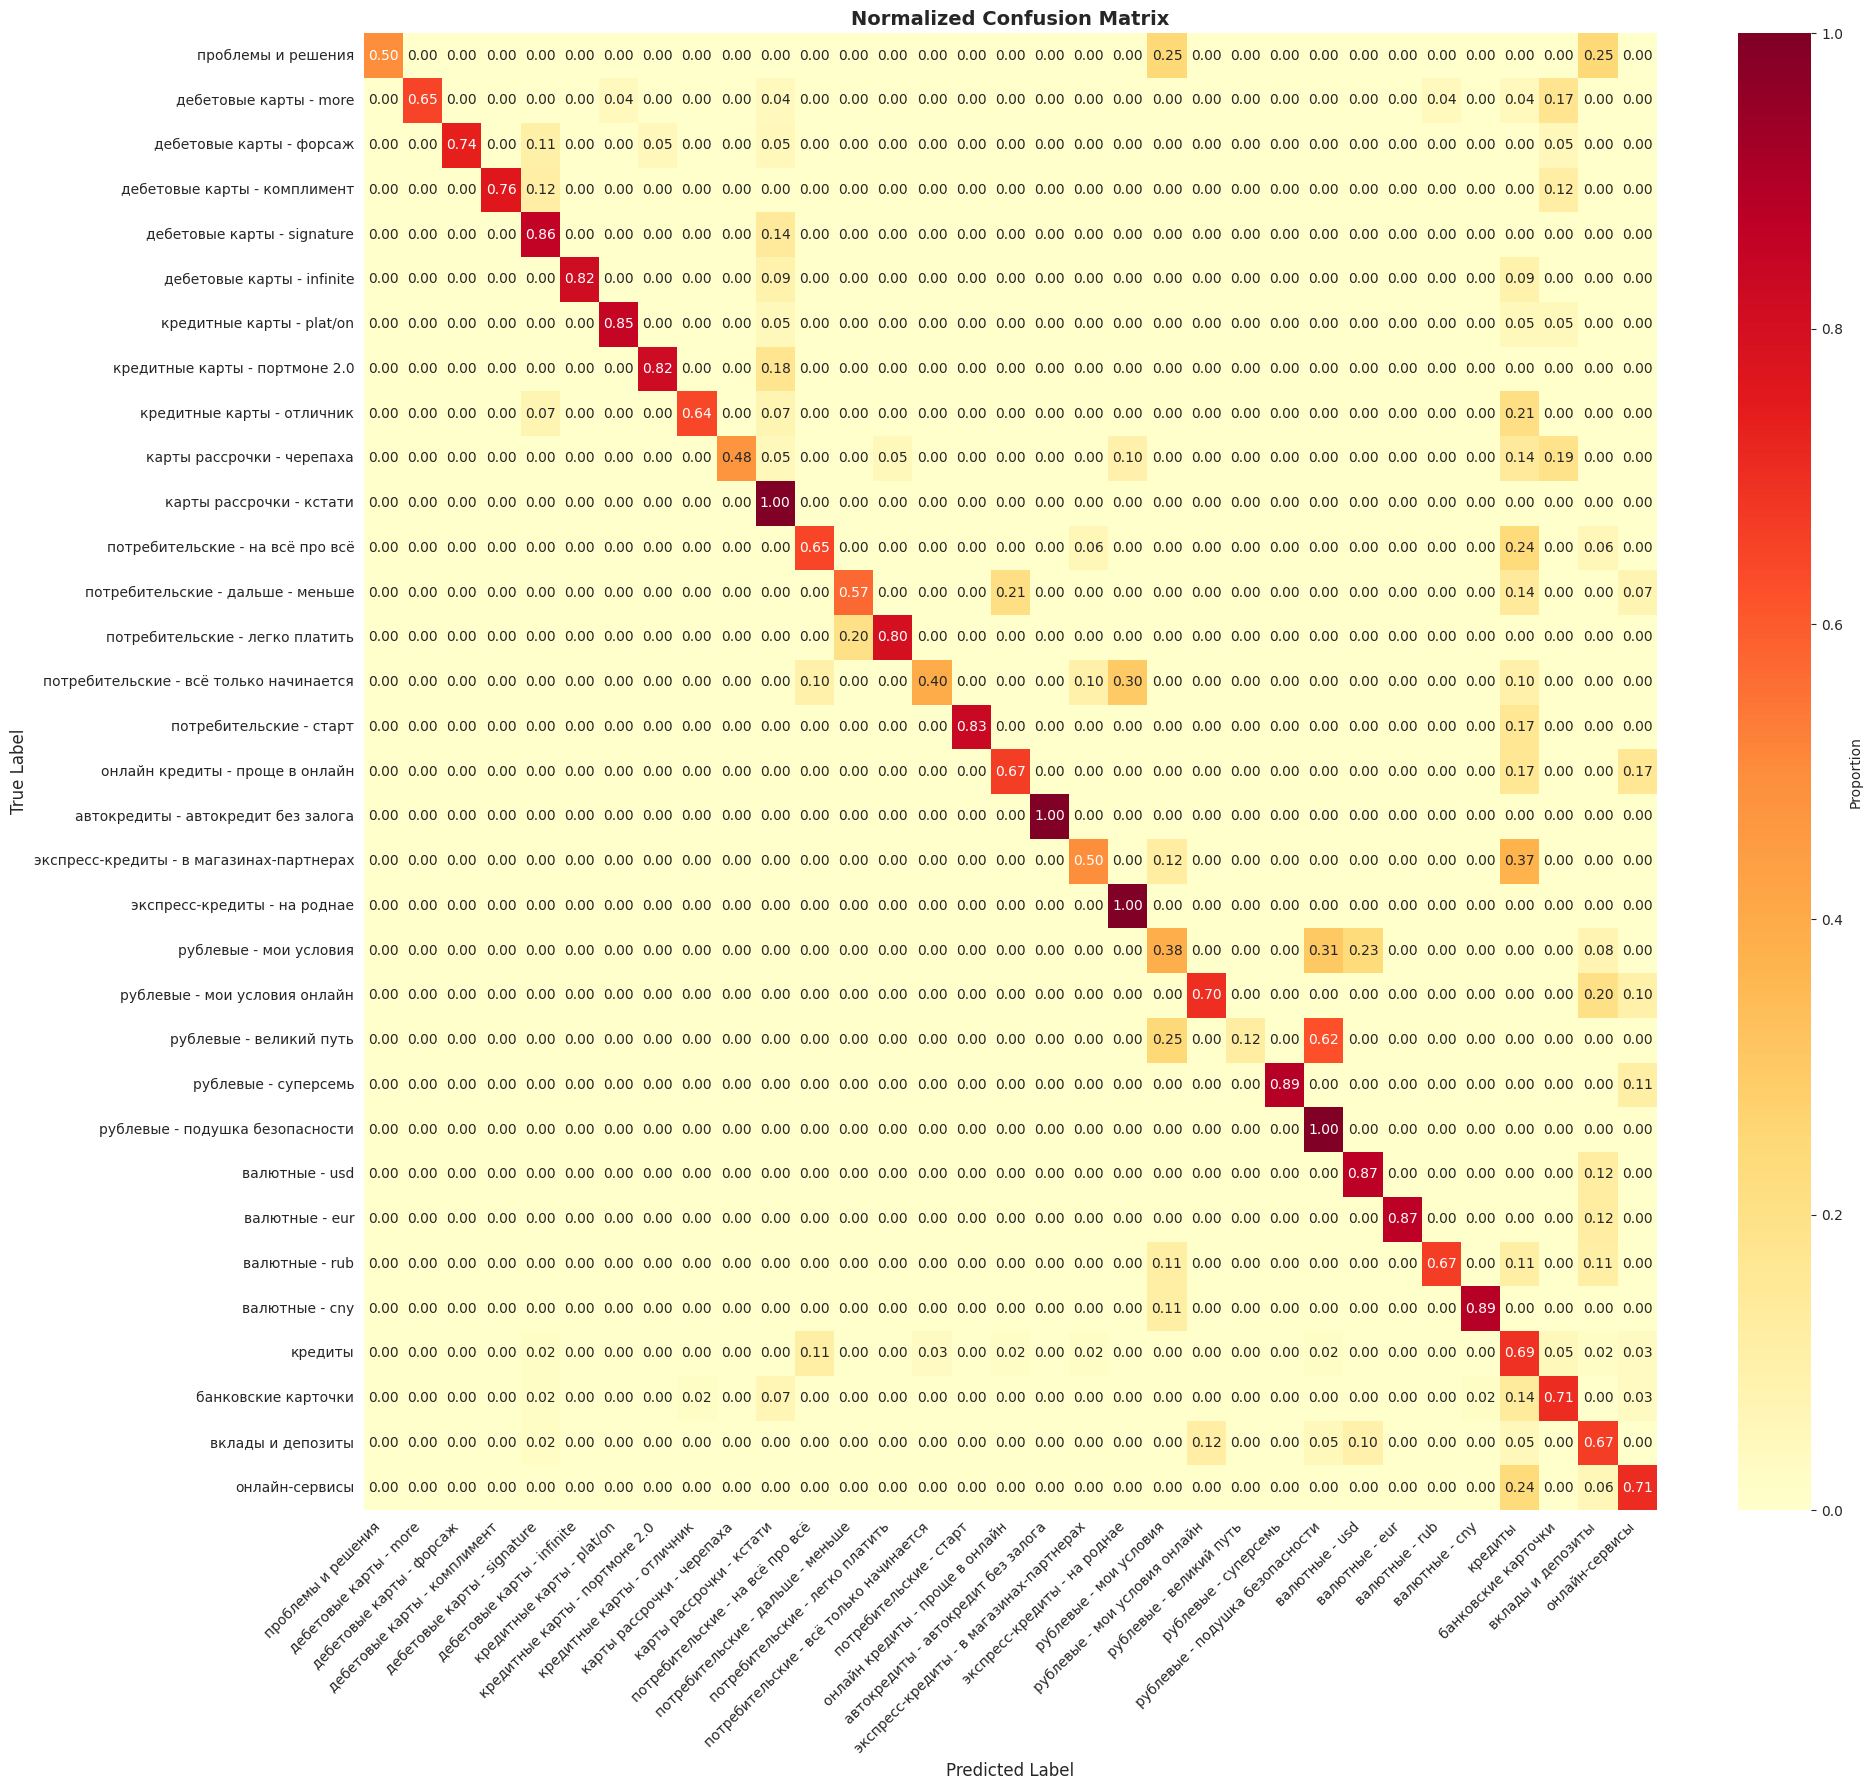


PER-CLASS PERFORMANCE ANALYSIS

Top 10 best performing classes:
                                     Precision    Recall  F1-Score  Support
автокредиты - автокредит без залога   1.000000  1.000000  1.000000     11.0
рублевые - суперсемь                  1.000000  0.888889  0.941176      9.0
валютные - eur                        1.000000  0.875000  0.933333      8.0
потребительские - старт               1.000000  0.833333  0.909091      6.0
дебетовые карты - infinite            1.000000  0.818182  0.900000     11.0
кредитные карты - plat/on             0.944444  0.850000  0.894737     20.0
валютные - cny                        0.888889  0.888889  0.888889      9.0
кредитные карты - портмоне 2.0        0.933333  0.823529  0.875000     17.0
дебетовые карты - комплимент          1.000000  0.764706  0.866667     17.0
дебетовые карты - форсаж              1.000000  0.736842  0.848485     19.0


Top 10 worst performing classes:
                                          Precision    Recall  F

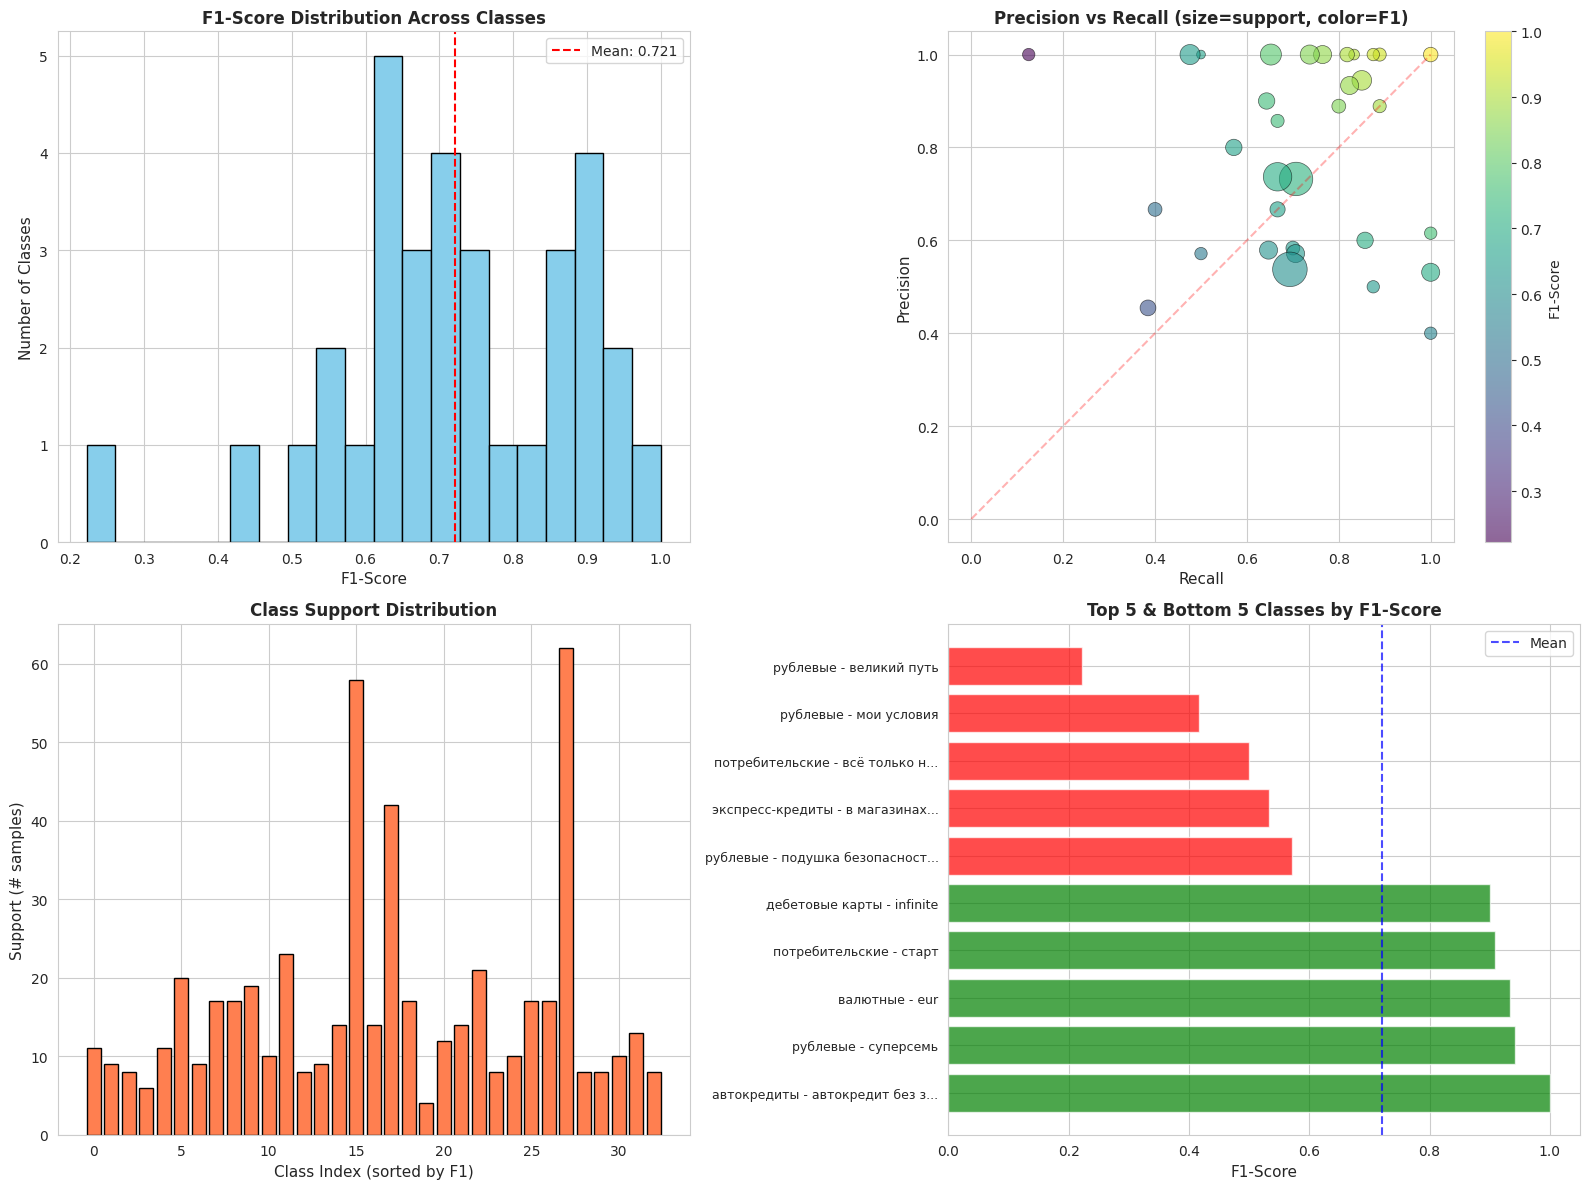


ROUTING ANALYSIS


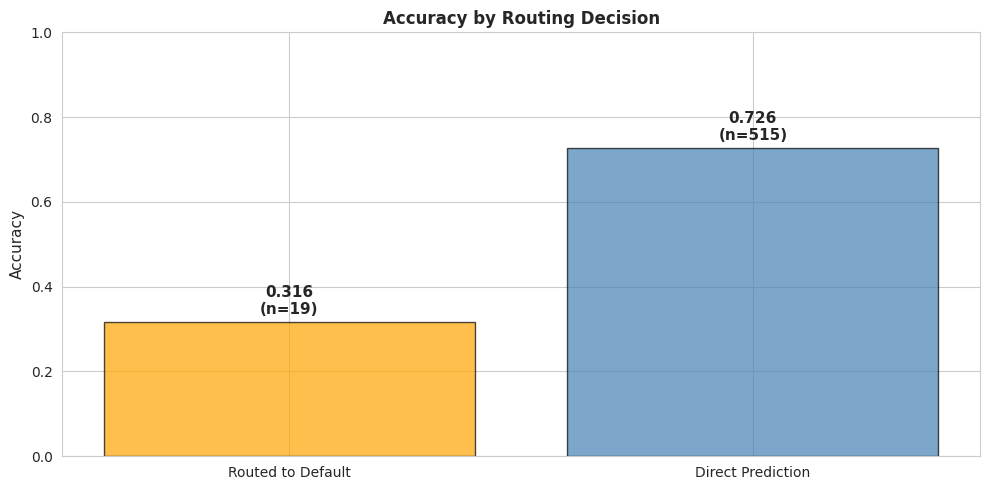


Routing Statistics:
  Routed to default:    19 (3.56%)
  Direct predictions:   515 (96.44%)
  Accuracy (routed):    0.316
  Accuracy (direct):    0.726

ERROR ANALYSIS - Sample Failures

Total errors: 154/534 (28.84%)

Sample of errors (first 10):

1. Test sample 1:
   True:       проблемы и решения
   Predicted:  вклады и депозиты
   Confidence: 0.711
   Routed:     False
   Top-3:      вклады и депозиты, онлайн-сервисы, кредиты

2. Test sample 12:
   True:       дебетовые карты - форсаж
   Predicted:  кредитные карты - портмоне 2.0
   Confidence: 0.675
   Routed:     False
   Top-3:      кредитные карты - портмоне 2.0, дебетовые карты - форсаж, дебетовые карты - signature

3. Test sample 20:
   True:       рублевые - великий путь
   Predicted:  рублевые - подушка безопасности
   Confidence: 0.721
   Routed:     False
   Top-3:      рублевые - подушка безопасности, рублевые - великий путь, рублевые - мои условия онлайн

4. Test sample 21:
   True:       потребительские - всё только н

In [59]:
# =============================================================================
# ANALYSIS & VISUALIZATION - Works with minimal model variables
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.calibration import calibration_curve
import pandas as pd
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)

print("="*80)
print("COMPREHENSIVE MODEL ANALYSIS")
print("="*80)

# ========== 1. CONFIDENCE ANALYSIS ==========
print("\n" + "="*80)
print("CONFIDENCE ANALYSIS")
print("="*80)

# Extract confidence and correctness
confidence_scores = pred_confidences
correct = (y_pred == y_true).astype(int)

# Calculate margins (difference between top-1 and top-2)
margins = []
for i in range(len(X_test_emb)):
    parent_pred_i = parent_map[y_pred[i]]
    children = np.where(parent_map == parent_pred_i)[0]
    
    if len(children) > 1:
        child_sims = protos[children] @ X_test_emb[i]
        sorted_sims = np.sort(child_sims)
        margin = sorted_sims[-1] - sorted_sims[-2]
    else:
        margin = 1.0  # Single child, full confidence
    
    margins.append(margin)

margins = np.array(margins)

plt.figure(figsize=(14, 10))

# 1. Confidence distribution
plt.subplot(2, 2, 1)
plt.hist(confidence_scores, bins=50, edgecolor='black', color='lightblue', alpha=0.7)
plt.xlabel('Prediction Confidence (Parent Probability)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Prediction Confidence Scores', fontsize=12, fontweight='bold')
plt.axvline(confidence_scores.mean(), color='red', linestyle='--', 
            label=f'Mean: {confidence_scores.mean():.3f}')
plt.axvline(np.median(confidence_scores), color='green', linestyle='--', 
            label=f'Median: {np.median(confidence_scores):.3f}')
plt.axvline(CONFIDENCE_THRESHOLD, color='orange', linestyle=':', linewidth=2,
            label=f'Threshold τ={CONFIDENCE_THRESHOLD}')
plt.legend()

# 2. Confidence vs Correctness
plt.subplot(2, 2, 2)
plt.scatter(confidence_scores, correct, alpha=0.4, s=20, c=correct, 
            cmap='RdYlGn', edgecolors='black', linewidth=0.5)
plt.xlabel('Prediction Confidence', fontsize=11)
plt.ylabel('Correct (1) / Incorrect (0)', fontsize=11)
plt.title('Confidence vs Prediction Correctness', fontsize=12, fontweight='bold')
plt.yticks([0, 1], ['Incorrect', 'Correct'])
plt.axvline(CONFIDENCE_THRESHOLD, color='orange', linestyle=':', linewidth=2, 
            alpha=0.7, label=f'τ={CONFIDENCE_THRESHOLD}')

correct_conf_mean = confidence_scores[correct == 1].mean()
incorrect_conf_mean = confidence_scores[correct == 0].mean()
plt.axvline(correct_conf_mean, color='green', linestyle='--', alpha=0.7,
            label=f'Correct mean: {correct_conf_mean:.3f}')
plt.axvline(incorrect_conf_mean, color='red', linestyle='--', alpha=0.7,
            label=f'Incorrect mean: {incorrect_conf_mean:.3f}')
plt.legend()

# 3. Margin analysis
plt.subplot(2, 2, 3)
plt.hist(margins, bins=50, edgecolor='black', color='coral', alpha=0.7)
plt.xlabel('Margin (P(top-1) - P(top-2))', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Decision Margins', fontsize=12, fontweight='bold')
plt.axvline(margins.mean(), color='red', linestyle='--', label=f'Mean: {margins.mean():.3f}')
plt.legend()

# 4. Margin vs Correctness
plt.subplot(2, 2, 4)
plt.scatter(margins, correct, alpha=0.4, s=20, c=correct, 
            cmap='RdYlGn', edgecolors='black', linewidth=0.5)
plt.xlabel('Decision Margin', fontsize=11)
plt.ylabel('Correct (1) / Incorrect (0)', fontsize=11)
plt.title('Margin vs Prediction Correctness', fontsize=12, fontweight='bold')
plt.yticks([0, 1], ['Incorrect', 'Correct'])

correct_margin_mean = margins[correct == 1].mean()
incorrect_margin_mean = margins[correct == 0].mean()
plt.axvline(correct_margin_mean, color='green', linestyle='--', alpha=0.7,
            label=f'Correct mean: {correct_margin_mean:.3f}')
plt.axvline(incorrect_margin_mean, color='red', linestyle='--', alpha=0.7,
            label=f'Incorrect mean: {incorrect_margin_mean:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nConfidence Statistics:")
print(f"  Mean confidence (correct):   {correct_conf_mean:.4f}")
print(f"  Mean confidence (incorrect): {incorrect_conf_mean:.4f}")
print(f"  Mean margin (correct):       {correct_margin_mean:.4f}")
print(f"  Mean margin (incorrect):     {incorrect_margin_mean:.4f}")
print(f"  Predictions above threshold: {(confidence_scores >= CONFIDENCE_THRESHOLD).sum()} ({(confidence_scores >= CONFIDENCE_THRESHOLD).mean():.2%})")
print(f"  Routed to default:           {pred_routed.sum()} ({pred_routed.mean():.2%})")

# ========== 2. TOP-K ACCURACY ANALYSIS ==========
print("\n" + "="*80)
print("TOP-K ACCURACY ANALYSIS")
print("="*80)

# Calculate top-3 accuracy
top3_correct = []
true_positions = []

for i in range(len(X_test_emb)):
    true_label = id2sub[y_true[i]]
    pred_top3 = responses[i]['top3']
    
    if true_label in pred_top3:
        top3_correct.append(1)
        true_positions.append(pred_top3.index(true_label) + 1)
    else:
        top3_correct.append(0)
        true_positions.append(4)  # Not in top-3

top3_correct = np.array(top3_correct)

plt.figure(figsize=(12, 5))

# 1. Top-1 vs Top-3 accuracy
plt.subplot(1, 2, 1)
accuracies = [correct.mean(), top3_correct.mean()]
bars = plt.bar(['Top-1\nAccuracy', 'Top-3\nAccuracy'], accuracies,
               color=['steelblue', 'lightcoral'], edgecolor='black', alpha=0.7)
plt.ylabel('Accuracy', fontsize=11)
plt.title('Top-K Accuracy Comparison', fontsize=12, fontweight='bold')
plt.ylim(0, 1)
for bar, val in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', fontsize=12, fontweight='bold')

# 2. Position of true label
plt.subplot(1, 2, 2)
pos_counts = pd.Series(true_positions).value_counts().sort_index()
colors_pos = ['green', 'orange', 'yellow', 'red']
plt.bar(range(len(pos_counts)), pos_counts.values, 
        color=[colors_pos[int(i)-1] if i <= 4 else colors_pos[-1] for i in pos_counts.index],
        edgecolor='black', alpha=0.7)
plt.xticks(range(len(pos_counts)), 
           [f'Rank {int(i)}' if i < 4 else 'Not in\nTop-3' for i in pos_counts.index])
plt.ylabel('Count', fontsize=11)
plt.title('Position of True Label in Top-3', fontsize=12, fontweight='bold')
for i, v in enumerate(pos_counts.values):
    plt.text(i, v + 5, f'{v}\n({v/len(true_positions)*100:.1f}%)', 
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nTop-K Accuracy:")
print(f"  Top-1: {correct.mean():.4f} ({correct.sum()}/{len(correct)})")
print(f"  Top-3: {top3_correct.mean():.4f} ({top3_correct.sum()}/{len(top3_correct)})")
print(f"\nTrue label position:")
for pos, count in pos_counts.items():
    if pos < 4:
        print(f"  Rank {int(pos)}: {count} ({count/len(true_positions):.2%})")
    else:
        print(f"  Not in top-3: {count} ({count/len(true_positions):.2%})")

# ========== 3. CALIBRATION CURVE ==========
print("\n" + "="*80)
print("CALIBRATION ANALYSIS")
print("="*80)

plt.figure(figsize=(14, 5))

# 1. Calibration curve
plt.subplot(1, 2, 1)
prob_true, prob_pred = calibration_curve(correct, confidence_scores, n_bins=10, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability', fontsize=11)
plt.ylabel('Fraction of Positives (Accuracy)', fontsize=11)
plt.title('Calibration Curve', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 2. Confidence distribution
plt.subplot(1, 2, 2)
plt.hist(confidence_scores, bins=20, weights=np.ones(len(confidence_scores)) / len(confidence_scores),
         alpha=0.6, edgecolor='black', label='Confidence distribution')
plt.xlabel('Predicted Probability', fontsize=11)
plt.ylabel('Proportion of Samples', fontsize=11)
plt.title('Confidence Score Distribution', fontsize=12, fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

ece = np.abs(prob_true - prob_pred).mean()
print(f"\nExpected Calibration Error (ECE): {ece:.4f}")
print(f"(Lower is better - 0 is perfect)")

# ========== 4. CONFUSION MATRIX ==========
print("\n" + "="*80)
print("CONFUSION MATRIX")
print("="*80)

# Build confusion matrix
unique_labels = sorted(list(set(y_true.tolist() + y_pred.tolist())))
label_names = [id2sub[i] for i in unique_labels]
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\nTotal classes: {len(unique_labels)}")
print(f"Total predictions: {len(y_true)}")

# ========== 5. NORMALIZED CONFUSION MATRIX ==========
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

plt.figure(figsize=(20, 18))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ========== 6. PER-CLASS PERFORMANCE ==========
print("\n" + "="*80)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("="*80)

# Use the already computed performance_df from the model
print("\nTop 10 best performing classes:")
print(performance_df.head(10)[['Precision', 'Recall', 'F1-Score', 'Support']].to_string())
print("\n" + "="*80 + "\n")
print("Top 10 worst performing classes:")
print(performance_df.tail(10)[['Precision', 'Recall', 'F1-Score', 'Support']].to_string())

# Visualize per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score distribution
axes[0, 0].hist(performance_df['F1-Score'], bins=20, edgecolor='black', color='skyblue')
axes[0, 0].set_xlabel('F1-Score', fontsize=11)
axes[0, 0].set_ylabel('Number of Classes', fontsize=11)
axes[0, 0].set_title('F1-Score Distribution Across Classes', fontsize=12, fontweight='bold')
axes[0, 0].axvline(performance_df['F1-Score'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {performance_df["F1-Score"].mean():.3f}')
axes[0, 0].legend()

# Precision vs Recall
scatter = axes[0, 1].scatter(performance_df['Recall'], performance_df['Precision'], 
                             s=performance_df['Support']*10, alpha=0.6, 
                             c=performance_df['F1-Score'],
                             cmap='viridis', edgecolors='black', linewidth=0.5)
axes[0, 1].set_xlabel('Recall', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision vs Recall (size=support, color=F1)', 
                      fontsize=12, fontweight='bold')
axes[0, 1].plot([0, 1], [0, 1], 'r--', alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='F1-Score')

# Support distribution
axes[1, 0].bar(range(len(performance_df)), performance_df['Support'].values, 
               color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Class Index (sorted by F1)', fontsize=11)
axes[1, 0].set_ylabel('Support (# samples)', fontsize=11)
axes[1, 0].set_title('Class Support Distribution', fontsize=12, fontweight='bold')

# Top/Bottom comparison
top_bottom = pd.concat([performance_df.head(5), performance_df.tail(5)])
x_pos = range(len(top_bottom))
axes[1, 1].barh(x_pos, top_bottom['F1-Score'], 
                color=['green']*5 + ['red']*5, alpha=0.7)
axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels([c[:30] + '...' if len(c) > 30 else c 
                             for c in top_bottom['Class']], fontsize=9)
axes[1, 1].set_xlabel('F1-Score', fontsize=11)
axes[1, 1].set_title('Top 5 & Bottom 5 Classes by F1-Score', 
                      fontsize=12, fontweight='bold')
axes[1, 1].axvline(performance_df['F1-Score'].mean(), color='blue', 
                    linestyle='--', label='Mean', alpha=0.7)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# ========== 7. ROUTING ANALYSIS ==========
print("\n" + "="*80)
print("ROUTING ANALYSIS")
print("="*80)

routed_mask = pred_routed
not_routed_mask = ~pred_routed

if routed_mask.sum() > 0:
    routed_acc = correct[routed_mask].mean()
    not_routed_acc = correct[not_routed_mask].mean()
    
    plt.figure(figsize=(10, 5))
    
    categories = ['Routed to Default', 'Direct Prediction']
    accuracies = [routed_acc, not_routed_acc]
    counts = [routed_mask.sum(), not_routed_mask.sum()]
    
    x = range(len(categories))
    bars = plt.bar(x, accuracies, color=['orange', 'steelblue'], 
                   edgecolor='black', alpha=0.7)
    
    plt.ylabel('Accuracy', fontsize=11)
    plt.title('Accuracy by Routing Decision', fontsize=12, fontweight='bold')
    plt.xticks(x, categories)
    plt.ylim(0, 1)
    
    for i, (bar, acc, count) in enumerate(zip(bars, accuracies, counts)):
        plt.text(bar.get_x() + bar.get_width()/2, acc + 0.02, 
                 f'{acc:.3f}\n(n={count})', 
                 ha='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nRouting Statistics:")
    print(f"  Routed to default:    {routed_mask.sum()} ({routed_mask.mean():.2%})")
    print(f"  Direct predictions:   {not_routed_mask.sum()} ({not_routed_mask.mean():.2%})")
    print(f"  Accuracy (routed):    {routed_acc:.3f}")
    print(f"  Accuracy (direct):    {not_routed_acc:.3f}")
else:
    print("\nNo samples were routed to default (all above threshold)")

# ========== 8. ERROR ANALYSIS ==========
print("\n" + "="*80)
print("ERROR ANALYSIS - Sample Failures")
print("="*80)

errors = [(i, responses[i]) for i in range(len(responses)) if not responses[i]['correct']]

print(f"\nTotal errors: {len(errors)}/{len(responses)} ({len(errors)/len(responses):.2%})")
print("\nSample of errors (first 10):")

for idx, (i, r) in enumerate(errors[:10], 1):
    print(f"\n{idx}. Test sample {i}:")
    print(f"   True:       {r['true_subcat']}")
    print(f"   Predicted:  {r['pred_subcat']}")
    print(f"   Confidence: {r['confidence']:.3f}")
    print(f"   Routed:     {r['routed']}")
    print(f"   Top-3:      {', '.join(r['top3'])}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


In [101]:
# unified_reranker_fixed.py - Production-ready retriever

from typing import Protocol, Optional
import numpy as np
from collections import defaultdict

class CategoryConstrainedRetriever:
    """
    Universal retrieval system - PICKLE SAFE VERSION.
    No lambda functions, no defaultdicts in __init__.
    """
    def __init__(
        self,
        classifier,
        parent_map: np.ndarray,
        train_query_embs: np.ndarray,
        train_answer_embs: np.ndarray,
        train_labels: np.ndarray,
        train_answers: list[str],
        conf_thresholds: tuple[float, float] = (0.65, 0.50),
        use_answer_embs: bool = True
    ):
        self.clf = classifier
        self.parent_map = parent_map
        self.conf_thresholds = conf_thresholds
        self.use_answer_embs = use_answer_embs
        
        # Choose embeddings for retrieval
        self.retrieval_embs = train_answer_embs if use_answer_embs else train_query_embs
        
        print(f"🔍 Retrieval mode: {'Answer embeddings' if use_answer_embs else 'Query embeddings'}")
        
        # Use REGULAR DICTS (not defaultdicts - pickle safe!)
        self.subcat_index = {}
        self.parent_index = {}
        self.global_index = {
            'embs': self.retrieval_embs,
            'answers': train_answers,
            'labels': train_labels
        }
        
        # Build indices
        for idx, (emb, answer, label) in enumerate(zip(self.retrieval_embs, train_answers, train_labels)):
            label = int(label)  # Ensure integer
            parent_id = int(parent_map[label])
            
            # Initialize if not exists
            if label not in self.subcat_index:
                self.subcat_index[label] = {'embs': [], 'answers': [], 'indices': []}
            
            if parent_id not in self.parent_index:
                self.parent_index[parent_id] = {'embs': [], 'answers': [], 'indices': []}
            
            # Append data
            self.subcat_index[label]['embs'].append(emb)
            self.subcat_index[label]['answers'].append(answer)
            self.subcat_index[label]['indices'].append(idx)
            
            self.parent_index[parent_id]['embs'].append(emb)
            self.parent_index[parent_id]['answers'].append(answer)
            self.parent_index[parent_id]['indices'].append(idx)
        
        # Convert to numpy
        for label in self.subcat_index:
            self.subcat_index[label]['embs'] = np.array(self.subcat_index[label]['embs'])
        
        for parent_id in self.parent_index:
            self.parent_index[parent_id]['embs'] = np.array(self.parent_index[parent_id]['embs'])
        
        print(f"✅ Indexed {len(train_answers)} training examples")
        print(f"   - {len(self.subcat_index)} subcategories")
        print(f"   - {len(self.parent_index)} parent categories")
    
    def _get_confidence(self, query_emb: np.ndarray, predicted_label: int) -> dict:
        """Extract confidence from classifier."""
        predicted_label = int(predicted_label)  # Ensure integer
        
        try:
            probs = self.clf.predict_proba(query_emb.reshape(1, -1))
            if probs is not None:
                parent_id = int(self.parent_map[predicted_label])
                
                # For hierarchical: extract parent and child confidence
                if hasattr(self.clf, 'predict_with_meta'):
                    meta = self.clf.predict_with_meta(query_emb.reshape(1, -1))
                    return {
                        'parent_id': int(meta['parent_id']),
                        'parent_conf': float(meta['parent_confidence']),
                        'child_conf': float(meta['child_confidence'])
                    }
                else:
                    # For flat classifiers
                    conf = float(probs[0, predicted_label])
                    return {
                        'parent_id': parent_id,
                        'parent_conf': conf,
                        'child_conf': conf
                    }
        except Exception as e:
            pass
        
        # Fallback
        return {
            'parent_id': int(self.parent_map[predicted_label]),
            'parent_conf': 0.5,
            'child_conf': 0.5
        }
    
    def retrieve(self, query_emb: np.ndarray, top_k: int = 1, return_metadata: bool = False):
        """Retrieve top-k answers for query."""
        # Predict category
        predicted_label = int(self.clf.predict(query_emb.reshape(1, -1))[0])
        
        # Get confidence
        conf_info = self._get_confidence(query_emb, predicted_label)
        parent_conf = conf_info['parent_conf']
        child_conf = conf_info['child_conf']
        parent_id = conf_info['parent_id']
        
        # Decide search scope
        subcat_thresh, parent_thresh = self.conf_thresholds
        
        if child_conf > subcat_thresh and predicted_label in self.subcat_index:
            scope = 'subcategory'
            candidate_embs = self.subcat_index[predicted_label]['embs']
            candidate_answers = self.subcat_index[predicted_label]['answers']
        
        elif parent_conf > parent_thresh and parent_id in self.parent_index:
            scope = 'parent'
            candidate_embs = self.parent_index[parent_id]['embs']
            candidate_answers = self.parent_index[parent_id]['answers']
        
        else:
            scope = 'global'
            candidate_embs = self.global_index['embs']
            candidate_answers = self.global_index['answers']
        
        # Compute similarities
        similarities = candidate_embs @ query_emb.flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        
        results = []
        for rank, idx in enumerate(top_indices):
            result = {
                'answer': candidate_answers[idx],
                'similarity': float(similarities[idx]),
                'rank': rank + 1
            }
            
            if return_metadata:
                result['metadata'] = {
                    'search_scope': scope,
                    'num_candidates': len(candidate_answers),
                    'parent_confidence': parent_conf,
                    'child_confidence': child_conf,
                    'predicted_label': predicted_label,
                    'predicted_parent': parent_id
                }
            
            results.append(result)
        
        return results[0] if top_k == 1 else results
    
    def evaluate(self, X_test: np.ndarray, y_test_answers: list[str], 
                 y_test_labels: np.ndarray = None, verbose: bool = True) -> dict:
        """Evaluate retrieval accuracy."""
        top1_correct = 0
        top3_correct = 0
        reciprocal_ranks = []
        
        category_correct = 0 if y_test_labels is not None else None
        
        scope_counts = defaultdict(int)
        scope_correct = defaultdict(int)
        
        for i, (query_emb, true_answer) in enumerate(zip(X_test, y_test_answers)):
            results = self.retrieve(query_emb, top_k=3, return_metadata=True)
            
            scope = results[0]['metadata']['search_scope']
            scope_counts[scope] += 1
            
            predicted_answers = [r['answer'] for r in results]
            
            # Check answer match
            if predicted_answers[0] == true_answer:
                top1_correct += 1
                scope_correct[scope] += 1
                reciprocal_ranks.append(1.0)
            elif true_answer in predicted_answers:
                top3_correct += 1
                rank = predicted_answers.index(true_answer) + 1
                reciprocal_ranks.append(1.0 / rank)
            else:
                reciprocal_ranks.append(0.0)
            
            # Check category match
            if y_test_labels is not None:
                predicted_label = results[0]['metadata']['predicted_label']
                true_label = int(y_test_labels[i])
                if predicted_label == true_label:
                    category_correct += 1
        
        n_test = len(X_test)
        mrr = np.mean(reciprocal_ranks)
        
        if verbose:
            print(f"\n📊 Retrieval Evaluation:")
            print(f"  Top-1 Answer Accuracy: {top1_correct/n_test:.3f} ({top1_correct}/{n_test})")
            print(f"  Top-3 Answer Accuracy: {(top1_correct + top3_correct)/n_test:.3f}")
            print(f"  Mean Reciprocal Rank:  {mrr:.3f}")
            
            if category_correct is not None:
                print(f"  Category Accuracy:     {category_correct/n_test:.3f} (should match classification)")
            
            print(f"\n  Search Scope Breakdown:")
            for scope in ['subcategory', 'parent', 'global']:
                if scope in scope_counts:
                    count = scope_counts[scope]
                    correct = scope_correct[scope]
                    print(f"    {scope:12s}: {count:3d} queries ({count/n_test*100:5.1f}%) → {correct/count:.3f} accuracy")
        
        return {
            'top1_accuracy': top1_correct / n_test,
            'top3_accuracy': (top1_correct + top3_correct) / n_test,
            'mrr': mrr,
            'category_accuracy': category_correct / n_test if category_correct is not None else None,
            'scope_breakdown': dict(scope_counts)
        }


In [102]:
# integration_hierarchical_fixed.py - Complete working pipeline

print("="*80)
print("HIERARCHICAL CLASSIFIER + ANSWER RETRIEVAL (FIXED)")
print("="*80)

# Train hierarchical classifier
protos_final = build_protos(X_train_emb, y_sub_train, desc_vecs)
final_model = HierarchicalClassifier(parent_C=PARENT_C, child_C=CHILD_C)
final_model.fit(X_train_emb, y_sub_train, y_cat_train, protos_final)

print("\n✅ Classifier trained")

# Create retriever
retriever_hierarchical = CategoryConstrainedRetriever(
    classifier=final_model,
    parent_map=parent_map,
    train_query_embs=E_train,  # Query embeddings
    train_answer_embs=E_answers_train,  # Answer embeddings
    train_labels=y_sub_train,  # Integer category IDs
    train_answers=answers_train,  # Answer texts (as list)
    conf_thresholds=(0.65, 0.50),
    use_answer_embs=True
)

# Evaluate with category labels
print("\n" + "="*80)
print("EVALUATION")
print("="*80)

# Convert test labels to integers
y_test_ids = np.array([sub2id[y] for y in y_test])

retrieval_results = retriever_hierarchical.evaluate(
    X_test=E_test,  # Test query embeddings
    y_test_answers=answers_test,  # Test answer texts
    y_test_labels=y_test_ids,  # Test category IDs (for verification)
    verbose=True
)

# Demo
print("\n" + "="*80)
print("DEMO INFERENCE")
print("="*80)

demo_text = "хочу взять кредит на машину"
demo_emb = l2(get_embeddings_batch_local([demo_text])[0])

result = retriever_hierarchical.retrieve(demo_emb, top_k=3, return_metadata=True)

print(f"\n{'='*60}")
print(f"Query: {demo_text}")
print(f"{'='*60}")
print(f"\n✅ Top Answer:")
print(f"   {result[0]['answer'][:300]}...")
print(f"\n📊 Metadata:")
print(f"   Similarity: {result[0]['similarity']:.3f}")
print(f"   Search Scope: {result[0]['metadata']['search_scope']}")
print(f"   Candidates Searched: {result[0]['metadata']['num_candidates']}")
print(f"   Classification Confidence: parent={result[0]['metadata']['parent_confidence']:.3f}, "
      f"child={result[0]['metadata']['child_confidence']:.3f}")
print(f"\n📋 Alternative Answers:")
for i, alt in enumerate(result[1:], 2):
    print(f"   {i}. {alt['answer'][:150]}... (similarity: {alt['similarity']:.3f})")


HIERARCHICAL CLASSIFIER + ANSWER RETRIEVAL (FIXED)

✅ Classifier trained
🔍 Retrieval mode: Answer embeddings
✅ Indexed 835 training examples
   - 33 subcategories
   - 5 parent categories

EVALUATION


KeyError: 'регистрация и онбординг'

In [ ]:
# save_load_fixed.py - Pickle-safe saving

import pickle

print("="*80)
print("SAVING PRODUCTION MODEL")
print("="*80)

# Build production model bundle
production_model = {
    'classifier': final_model,
    'retriever': retriever_hierarchical,  # Already pickle-safe (no lambdas!)
    'protos': protos_final,
    'mappings': {
        'sub2id': sub2id,
        'id2sub': id2sub,
        'cat2id': cat2id,
        'id2cat': id2cat,
        'parent_map': parent_map,
        'sub2cat': sub2cat
    },
    'config': {
        'parent_C': PARENT_C,
        'child_C': CHILD_C,
        'alpha': ALPHA,
        'conf_thresholds': (0.65, 0.50),
        'use_answer_embs': True
    }
}

# Save
try:
    with open('production_classifier_retriever.pkl', 'wb') as f:
        pickle.dump(production_model, f)
    
    print("✅ Model saved to production_classifier_retriever.pkl")
    
    # Verify by loading
    with open('production_classifier_retriever.pkl', 'rb') as f:
        loaded = pickle.load(f)
    
    print("✅ Load verification passed")
    
except Exception as e:
    print(f"❌ Save failed: {e}")
    raise
# save_load_fixed.py - Pickle-safe saving

import pickle

print("="*80)
print("SAVING PRODUCTION MODEL")
print("="*80)

# Build production model bundle
production_model = {
    'classifier': final_model,
    'retriever': retriever_hierarchical,  # Already pickle-safe (no lambdas!)
    'protos': protos_final,
    'mappings': {
        'sub2id': sub2id,
        'id2sub': id2sub,
        'cat2id': cat2id,
        'id2cat': id2cat,
        'parent_map': parent_map,
        'sub2cat': sub2cat
    },
    'config': {
        'parent_C': PARENT_C,
        'child_C': CHILD_C,
        'alpha': ALPHA,
        'conf_thresholds': (0.65, 0.50),
        'use_answer_embs': True
    }
}

# Save
try:
    with open('production_classifier_retriever.pkl', 'wb') as f:
        pickle.dump(production_model, f)
    
    print("✅ Model saved to production_classifier_retriever.pkl")
    
    # Verify by loading
    with open('production_classifier_retriever.pkl', 'rb') as f:
        loaded = pickle.load(f)
    
    print("✅ Load verification passed")
    
except Exception as e:
    print(f"❌ Save failed: {e}")
    raise


In [ ]:
# complete_working_example.py - Drop this into a cell and run

print("="*80)
print("COMPLETE HIERARCHICAL RETRIEVAL PIPELINE")
print("="*80)

# ========== STEP 1: TRAIN CLASSIFIER ==========
print("\n[1/4] Training hierarchical classifier...")

protos_final = build_protos(E_train, y_sub_train, desc_vecs)
clf = HierarchicalClassifier(parent_C=5.0, child_C=2.0)
clf.fit(E_train, y_sub_train, y_cat_train, protos_final)

# Quick classification evaluation
y_pred_test = clf.predict(E_test)
parent_pred = np.array([parent_map[p] for p in y_pred_test])
parent_true = np.array([parent_map[t] for t in y_sub_test])

print(f"   ✅ Classifier trained")
print(f"      Parent accuracy: {(parent_pred == parent_true).mean():.3f}")
print(f"      Child accuracy:  {(y_pred_test == y_sub_test).mean():.3f}")

# ========== STEP 2: BUILD RETRIEVER ==========
print("\n[2/4] Building retrieval system...")

retriever = CategoryConstrainedRetriever(
    classifier=clf,
    parent_map=parent_map,
    train_query_embs=E_train,
    train_answer_embs=E_answers_train,
    train_labels=y_sub_train,
    train_answers=answers_train,
    conf_thresholds=(0.65, 0.50),
    use_answer_embs=True
)

# ========== STEP 3: EVALUATE ==========
print("\n[3/4] Evaluating retrieval...")

results = retriever.evaluate(
    X_test=E_test,
    y_test_answers=answers_test,
    y_test_labels=y_sub_test,
    verbose=True
)

# ========== STEP 4: DEMO ==========
print("\n[4/4] Demo inference...")

demo_queries = [
    "хочу взять кредит на машину",
    "какие условия по вкладам?",
    "не могу войти в приложение"
]

for query in demo_queries:
    emb = l2(get_embeddings_batch_local([query])[0])
    result = retriever.retrieve(emb, top_k=1, return_metadata=True)
    
    print(f"\n{'='*60}")
    print(f"Q: {query}")
    print(f"A: {result[0]['answer'][:150]}...")
    print(f"   Similarity: {result[0]['similarity']:.3f}")
    print(f"   Scope: {result[0]['metadata']['search_scope']}")

print("\n" + "="*80)
print("✅ PIPELINE COMPLETE")
print("="*80)


In [46]:
# ========== DIAGNOSTIC: Check for semantic collapse ==========
print("\n" + "="*80)
print("🔍 DIAGNOSTIC: Semantic Collapse Analysis")
print("="*80)

# Group subcategories by parent
from collections import defaultdict
subs_by_parent = defaultdict(list)
for sub_id in range(N_SUB):
    parent_id = parent_map[sub_id]
    subs_by_parent[parent_id].append(sub_id)

print("\nSubcategories per parent:")
for parent_id, sub_ids in subs_by_parent.items():
    print(f"\n{id2cat[parent_id]} ({len(sub_ids)} subcategories):")
    for sub_id in sub_ids:
        support_train = (y_sub_train == sub_id).sum()
        support_test = (y_sub_test == sub_id).sum()
        print(f"  - {id2sub[sub_id]}: train={support_train}, test={support_test}")

# Check intra-parent similarity
print("\n" + "="*80)
print("Intra-Parent Prototype Similarity (are siblings too similar?)")
print("="*80)

for parent_id, sub_ids in subs_by_parent.items():
    if len(sub_ids) < 2:
        continue
    
    # Get prototypes for this parent's children
    parent_protos = protos_final[sub_ids]
    
    # Compute pairwise similarities
    sims = parent_protos @ parent_protos.T
    
    # Average off-diagonal similarity
    mask = ~np.eye(len(sub_ids), dtype=bool)
    avg_sim = sims[mask].mean()
    max_sim = sims[mask].max()
    
    print(f"\n{id2cat[parent_id]}:")
    print(f"  Avg sibling similarity: {avg_sim:.3f}")
    print(f"  Max sibling similarity: {max_sim:.3f}")
    
    # Show most confused pairs
    if max_sim > 0.85:
        print(f"  ⚠️  HIGH CONFUSION - siblings are too similar!")
        for i in range(len(sub_ids)):
            for j in range(i+1, len(sub_ids)):
                if sims[i, j] > 0.85:
                    print(f"     {id2sub[sub_ids[i]]} <-> {id2sub[sub_ids[j]]}: {sims[i, j]:.3f}")

# Check inter-parent separation
print("\n" + "="*80)
print("Inter-Parent Separation (are parents well-separated?)")
print("="*80)

parent_centroids = []
for parent_id in range(N_CAT):
    mask = parent_map == parent_id
    parent_centroids.append(protos_final[mask].mean(0))

parent_centroids = np.array(parent_centroids)
parent_centroids = l2(parent_centroids)

parent_sims = parent_centroids @ parent_centroids.T
mask = ~np.eye(N_CAT, dtype=bool)
avg_parent_sep = parent_sims[mask].mean()

print(f"Average inter-parent similarity: {avg_parent_sep:.3f}")
print(f"(Lower is better - want <0.5 for clean separation)")

for i in range(N_CAT):
    for j in range(i+1, N_CAT):
        if parent_sims[i, j] > 0.60:
            print(f"  ⚠️  {id2cat[i]} <-> {id2cat[j]}: {parent_sims[i, j]:.3f} (TOO SIMILAR)")

# Analyze failed classes specifically
print("\n" + "="*80)
print("Failed Classes Analysis (0.0-0.4 F1)")
print("="*80)

failed_classes = performance_df[performance_df['F1-Score'] < 0.4]['Class'].tolist()
print(f"Found {len(failed_classes)} failed classes")

for cls_name in failed_classes:
    if cls_name not in sub2id:
        continue
    
    cls_id = sub2id[cls_name]
    parent_id = parent_map[cls_id]
    
    # Get test samples for this class
    test_indices = np.where(y_sub_test == cls_id)[0]
    if len(test_indices) == 0:
        continue
    
    print(f"\n{cls_name} (parent: {id2cat[parent_id]}):")
    print(f"  Test samples: {len(test_indices)}")
    
    # Check what model predicted for these samples
    predictions = y_pred[test_indices]
    pred_names = [id2sub[p] for p in predictions]
    pred_parents = [id2cat[parent_map[p]] for p in predictions]
    
    print(f"  Predicted as:")
    for pred_name, pred_parent in zip(pred_names, pred_parents):
        marker = "✓" if pred_parent == id2cat[parent_id] else "✗"
        print(f"    {marker} {pred_name} (parent: {pred_parent})")
    
    # Check prototype similarity to siblings
    siblings = [s for s in range(N_SUB) if parent_map[s] == parent_id and s != cls_id]
    if siblings:
        sims_to_siblings = protos_final[siblings] @ protos_final[cls_id]
        max_sib_sim = sims_to_siblings.max()
        most_similar_sib = siblings[sims_to_siblings.argmax()]
        print(f"  Most similar sibling: {id2sub[most_similar_sib]} (sim={max_sib_sim:.3f})")

# Check if adding negative features would help
print("\n" + "="*80)
print("Hypothesis: Would Negative Features Help?")
print("="*80)

# For each failed class, compute its separability score
for cls_name in failed_classes[:5]:  # Top 5 failed
    if cls_name not in sub2id:
        continue
    
    cls_id = sub2id[cls_name]
    parent_id = parent_map[cls_id]
    
    # Positive: similarity to own prototype
    test_indices = np.where(y_sub_test == cls_id)[0]
    if len(test_indices) == 0:
        continue
    
    pos_sims = []
    neg_sims = []
    
    for idx in test_indices:
        x = X_test_emb[idx]
        
        # Similarity to own prototype
        pos_sim = protos_final[cls_id] @ x
        pos_sims.append(pos_sim)
        
        # Max similarity to siblings (within same parent)
        siblings = [s for s in range(N_SUB) if parent_map[s] == parent_id and s != cls_id]
        if siblings:
            neg_sim = max(protos_final[siblings] @ x)
            neg_sims.append(neg_sim)
    
    if pos_sims and neg_sims:
        avg_pos = np.mean(pos_sims)
        avg_neg = np.mean(neg_sims)
        margin = avg_pos - avg_neg
        
        print(f"\n{cls_name}:")
        print(f"  Avg similarity to own prototype: {avg_pos:.3f}")
        print(f"  Avg similarity to closest sibling: {avg_neg:.3f}")
        print(f"  Margin: {margin:.3f}")
        
        if margin < 0.05:
            print(f"  ⚠️  CRITICAL: Margin too small! Samples are equidistant to multiple prototypes")
        elif margin < 0.10:
            print(f"  ⚠️  WARNING: Margin is weak. Adding negative features may help")
        else:
            print(f"  ✓ Margin is sufficient. Problem is elsewhere (maybe data quality)")





🔍 DIAGNOSTIC: Semantic Collapse Analysis

Subcategories per parent:

техническая поддержка (1 subcategories):
  - проблемы и решения: train=6, test=4

продукты - карты (10 subcategories):
  - дебетовые карты - more: train=32, test=23
  - дебетовые карты - форсаж: train=25, test=19
  - дебетовые карты - комплимент: train=23, test=17
  - дебетовые карты - signature: train=19, test=14
  - дебетовые карты - infinite: train=15, test=11
  - кредитные карты - plat/on: train=28, test=20
  - кредитные карты - портмоне 2.0: train=23, test=17
  - кредитные карты - отличник: train=17, test=14
  - карты рассрочки - черепаха: train=30, test=21
  - карты рассрочки - кстати: train=23, test=17

продукты - кредиты (9 subcategories):
  - потребительские - на всё про всё: train=22, test=17
  - потребительские - дальше - меньше: train=19, test=14
  - потребительские - легко платить: train=15, test=10
  - потребительские - всё только начинается: train=15, test=10
  - потребительские - старт: train=7, test=

## Re-ranking / retrieval

In [ ]:
# unified_reranker.py - Category-constrained retrieval for any classifier
"""
Works with:
- kNN classifier
- Hierarchical classifier
- Any classifier that returns predictions + confidence

Strategy:
1. Classifier predicts category
2. Retrieve answer from constrained search space
3. Return answer text (not category name)
"""

from typing import Protocol, Optional
import numpy as np
from collections import defaultdict

class ClassifierProtocol(Protocol):
    """Interface any classifier must implement."""
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Return predicted category IDs."""
        ...
    
    def predict_proba(self, X: np.ndarray) -> Optional[np.ndarray]:
        """Return prediction probabilities (optional)."""
        ...


class UnifiedRetriever:
    """
    Universal retrieval system that works with any classifier.
    
    Key insight: Classification narrows search space, 
    then we match query embedding to ANSWER embeddings.
    """
    def __init__(
        self,
        classifier: ClassifierProtocol,
        parent_map: np.ndarray,
        train_query_embs: np.ndarray,      # Query embeddings (for kNN fallback)
        train_answer_embs: np.ndarray,     # Answer embeddings (for retrieval)
        train_labels: np.ndarray,          # Category labels
        train_answers: list[str],          # Answer texts
        conf_thresholds: tuple[float, float] = (0.65, 0.50),
        use_answer_embs: bool = True       # If False, use query embeddings (old behavior)
    ):
        self.clf = classifier
        self.parent_map = parent_map
        self.conf_thresholds = conf_thresholds
        self.use_answer_embs = use_answer_embs
        
        # Decide which embeddings to use for retrieval
        self.retrieval_embs = train_answer_embs if use_answer_embs else train_query_embs
        
        print(f"🔍 Retrieval mode: {'Answer embeddings' if use_answer_embs else 'Query embeddings'}")
        
        # Build indices by category
        self.subcat_index = defaultdict(lambda: {'embs': [], 'answers': [], 'indices': []})
        self.parent_index = defaultdict(lambda: {'embs': [], 'answers': [], 'indices': []})
        self.global_index = {
            'embs': self.retrieval_embs,
            'answers': train_answers,
            'labels': train_labels
        }
        
        for idx, (emb, answer, label) in enumerate(zip(self.retrieval_embs, train_answers, train_labels)):
            parent_id = parent_map[label]
            
            # Index by subcategory
            self.subcat_index[label]['embs'].append(emb)
            self.subcat_index[label]['answers'].append(answer)
            self.subcat_index[label]['indices'].append(idx)
            
            # Index by parent category
            self.parent_index[parent_id]['embs'].append(emb)
            self.parent_index[parent_id]['answers'].append(answer)
            self.parent_index[parent_id]['indices'].append(idx)
        
        # Convert to numpy
        for label in self.subcat_index:
            self.subcat_index[label]['embs'] = np.array(self.subcat_index[label]['embs'])
        
        for parent_id in self.parent_index:
            self.parent_index[parent_id]['embs'] = np.array(self.parent_index[parent_id]['embs'])
        
        print(f"✅ Indexed {len(train_answers)} training examples")
        print(f"   - {len(self.subcat_index)} subcategories")
        print(f"   - {len(self.parent_index)} parent categories")
    
    def _get_confidence(self, query_emb: np.ndarray, predicted_label: int) -> dict:
        """Extract confidence from classifier (works with any classifier)."""
        try:
            # Try to get probabilities
            probs = self.clf.predict_proba(query_emb.reshape(1, -1))
            if probs is not None:
                parent_id = self.parent_map[predicted_label]
                
                # For hierarchical: extract parent and child confidence
                if hasattr(self.clf, 'predict_with_meta'):
                    meta = self.clf.predict_with_meta(query_emb.reshape(1, -1))
                    return {
                        'parent_id': meta['parent_id'],
                        'parent_conf': meta['parent_confidence'],
                        'child_conf': meta['child_confidence']
                    }
                else:
                    # For flat classifiers: use predicted class probability
                    conf = probs[0, predicted_label]
                    return {
                        'parent_id': parent_id,
                        'parent_conf': conf,
                        'child_conf': conf
                    }
        except:
            pass
        
        # Fallback: no confidence available
        return {
            'parent_id': self.parent_map[predicted_label],
            'parent_conf': 0.5,
            'child_conf': 0.5
        }
    
    def retrieve(self, query_emb: np.ndarray, top_k: int = 1, return_metadata: bool = False) -> dict | list[dict]:
        """
        Retrieve top-k answers for query.
        
        Args:
            query_emb: Query embedding (1024-dim)
            top_k: Number of answers to return
            return_metadata: Include debug info
        
        Returns:
            Single dict (if top_k=1) or list of dicts with:
                - answer: Answer text
                - similarity: Cosine similarity score
                - search_scope: 'subcategory' | 'parent' | 'global'
                - confidence: Classification confidence
        """
        # Predict category
        predicted_label = self.clf.predict(query_emb.reshape(1, -1))[0]
        
        # Get confidence
        conf_info = self._get_confidence(query_emb, predicted_label)
        parent_conf = conf_info['parent_conf']
        child_conf = conf_info['child_conf']
        parent_id = conf_info['parent_id']
        
        # Decide search scope based on confidence
        subcat_thresh, parent_thresh = self.conf_thresholds
        
        if child_conf > subcat_thresh and predicted_label in self.subcat_index:
            # HIGH confidence → search within predicted subcategory
            scope = 'subcategory'
            candidate_embs = self.subcat_index[predicted_label]['embs']
            candidate_answers = self.subcat_index[predicted_label]['answers']
        
        elif parent_conf > parent_thresh and parent_id in self.parent_index:
            # MEDIUM confidence → search within parent category
            scope = 'parent'
            candidate_embs = self.parent_index[parent_id]['embs']
            candidate_answers = self.parent_index[parent_id]['answers']
        
        else:
            # LOW confidence → global search
            scope = 'global'
            candidate_embs = self.global_index['embs']
            candidate_answers = self.global_index['answers']
        
        # Compute similarities to ANSWER embeddings
        similarities = candidate_embs @ query_emb.flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        
        results = []
        for rank, idx in enumerate(top_indices):
            result = {
                'answer': candidate_answers[idx],
                'similarity': float(similarities[idx]),
                'rank': rank + 1
            }
            
            if return_metadata:
                result['metadata'] = {
                    'search_scope': scope,
                    'num_candidates': len(candidate_answers),
                    'parent_confidence': parent_conf,
                    'child_confidence': child_conf,
                    'predicted_label': predicted_label,
                    'predicted_parent': parent_id
                }
            
            results.append(result)
        
        return results[0] if top_k == 1 else results
    
    def evaluate(self, X_test: np.ndarray, y_test_answers: list[str], verbose: bool = True) -> dict:
        """
        Evaluate retrieval accuracy on test set.
        
        Metrics:
        - Top-1 answer accuracy: % of times correct answer is rank 1
        - Top-3 answer accuracy: % of times correct answer is in top 3
        - MRR (Mean Reciprocal Rank)
        """
        top1_correct = 0
        top3_correct = 0
        reciprocal_ranks = []
        
        scope_counts = defaultdict(int)
        scope_correct = defaultdict(int)
        
        for i, (query_emb, true_answer) in enumerate(zip(X_test, y_test_answers)):
            # Get top-3 predictions
            results = self.retrieve(query_emb, top_k=3, return_metadata=True)
            
            scope = results[0]['metadata']['search_scope']
            scope_counts[scope] += 1
            
            # Check if correct answer is in top-k
            predicted_answers = [r['answer'] for r in results]
            
            if predicted_answers[0] == true_answer:
                top1_correct += 1
                scope_correct[scope] += 1
                reciprocal_ranks.append(1.0)
            elif true_answer in predicted_answers:
                top3_correct += 1
                rank = predicted_answers.index(true_answer) + 1
                reciprocal_ranks.append(1.0 / rank)
            else:
                reciprocal_ranks.append(0.0)
        
        n_test = len(X_test)
        mrr = np.mean(reciprocal_ranks)
        
        if verbose:
            print(f"\n📊 Retrieval Evaluation:")
            print(f"  Top-1 Answer Accuracy: {top1_correct/n_test:.3f} ({top1_correct}/{n_test})")
            print(f"  Top-3 Answer Accuracy: {(top1_correct + top3_correct)/n_test:.3f}")
            print(f"  Mean Reciprocal Rank:  {mrr:.3f}")
            print(f"\n  Search Scope Breakdown:")
            for scope in ['subcategory', 'parent', 'global']:
                if scope in scope_counts:
                    count = scope_counts[scope]
                    correct = scope_correct[scope]
                    print(f"    {scope:12s}: {count:3d} queries ({count/n_test*100:5.1f}%) → {correct/count:.3f} accuracy")
        
        return {
            'top1_accuracy': top1_correct / n_test,
            'top3_accuracy': (top1_correct + top3_correct) / n_test,
            'mrr': mrr,
            'scope_breakdown': {
                scope: {'count': scope_counts[scope], 'accuracy': scope_correct[scope] / scope_counts[scope]}
                for scope in scope_counts
            }
        }


In [65]:
import pandas as pd
from openai import OpenAI
import json
import time
json_name = "added_data_qwen.json"
df = pd.read_csv("./data.csv", sep=";")
with open(json_name, 'r', encoding="utf-8") as file:
    loaded_data = json.load(file)

client = OpenAI(
    api_key="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",
    base_url="https://openrouter.ai/api/v1"
)


system_prompt = "Ты являешься новым клиентом банка. Тебе дано утверждение. Придумай 3-7 вопросов, на которые отвечает данное утверждение. За каждый корректный и уникальный вопрос ты получишь 100$. Вопрос не является корректным если в утверждении нет однозначного ответа, или вопрос слишком конкретный, или если вопрос слишком неестественный. В случае неккорекного вопроса с твоего счета будет вычтено 1000$.В ответе дожны быть ТОЛЬКО ВОПРОСЫ, разделенные переходом на новую линию, ничего более. Вопрос должен звучать естественно, как обычно реально задают вопрос клиенты, со всеми неточностями. Вопрос не должен быть слишком конкретный, потому что реально так не обащются."
for index, value in df.iterrows():
    if value["answer_pattern"] in loaded_data:
        continue
    print(value["answer_pattern"])

    response = client.chat.completions.create(
        model="qwen/qwen3-235b-a22b:free",
        messages=[
            {"role": "system", "content": f"{system_prompt}"},
            {
                "role": "user",
                "content": f"Категория утверждения - {value["category"]}, подкатегория - {value['subcategory']}, утверждение - {value['answer_pattern']}, пример вопроса к утверждению - {value['text']}",
            }
        ]
    )

    print(response.choices[0].message)
    loaded_data[value["answer_pattern"]] = response.choices[0].message.content.split("\n")

    with open(json_name, 'w', encoding="utf-8") as file:
        json.dump(loaded_data, file, indent = 4, ensure_ascii=False)
    
    time.sleep(1)

Карточку PLAT/ON можно оформить в интернет-банке или М-банкинге, в том числе виртуальную карточку, а также обратившись в любой офис Банка.


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-day. Add 10 credits to unlock 1000 free model requests per day', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '50', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1760572800000'}, 'provider_name': None}}, 'user_id': 'user_2Yj7hd7R4IV1qoKuyjLq9Aq92Bi'}